<a href="https://colab.research.google.com/github/AndrewDiv/PMfMIVV/blob/main/DiplomaUpd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [3]:
import numpy as np
import time
from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib inline

# Simulator

In [4]:
def Prevalence(host_num, single_strain_prob = 0.3):
  """ Simulate prevalence of strains in the host
    
  Parameters
  ----------
  host_num : int
    Number of patients
  single_strain_prob : float
    The probability that the host carries only one strain
       
  Returns
  -------
  prevs: ndarray, shape (host_num,)
    List of prevalence of one strain
  """
  prevs = np.zeros(host_num)
  for i in range(host_num):
    rnd = np.random.uniform()
    if rnd < single_strain_prob:
      prevs[i] = np.random.choice([0., 1.])
    else:
      prevs[i] = np.random.uniform()
  return prevs

In [5]:
def pi_i(r_s, prevs, er_rate):
  return prevs*(r_s[0]*(1 - er_rate) + (1 - r_s[0])*er_rate) + (1-prevs)*(r_s[1]*(1 - er_rate) + (1 - r_s[1])*er_rate)

def SimulateReads(haps, prevs, coverage = 100,  er_rate = 0.01):
  """ Simulate reads from one host
    
  Parameters
  ----------
  haps : ndarray, shape (n, m)
    List of haplotypes
  prevs: ndarray, shape (k,)
    List of prevalences
  coverage: int
    Number of reads that cover sites
  er_rate: float
    Error rate 
       
  Returns
  -------
  data: ndarray, shape (host_num, hap_len, hap_num)
    Array of the number of observations of different alleles at each site
     for all patients
  """
  hap_len = len(haps[0])
  hap_num = len(haps)
  host_num = prevs.shape[0]
  data = np.empty((host_num, hap_len, hap_num))
  #print(hap_len, hap_num)
  for host in range(host_num):
    for snv in range(hap_len):
      als = np.zeros(hap_num)
      lcoverage = coverage
      als[1] = np.random.binomial(lcoverage, pi_i([haps[0][snv], haps[1][snv]], prevs[host], er_rate))
      als[0] = lcoverage - als[1]
      data[host][snv] = als
    
  return data

# Log-Likelihood

In [6]:
def LogFactorial(n):
  return sum(np.log(np.arange(1, n+1)))

def Coeff(reads):
  coeff = 0
  for _reads in reads:
    coeff += LogFactorial(_reads[0] + _reads[1]) - LogFactorial(_reads[1]) - LogFactorial(_reads[0])
  return coeff

In [7]:
def SingleHostLLH(prev, haps, samp_reads, er_rate=0.):
  """ Calculate minus log-likelihood of a single host
    
  Parameters
  ----------
  prev : float
    prevalence of 1st strain
  haps : ndarray, shape (hap_num, hap_len)
    List of haplotypes
  samp_reads: ndarray, shape (hap_len, hap_num)
    reads of host
  er_rate: float
    Error rate 
       
  Returns
  -------
  -llh: float
    log-likelihood of a single host
  """
  llh = Coeff(samp_reads)
  for snv in range(len(samp_reads)):
    p = prev*(haps[0][snv]*(1.0 - er_rate) + (1.0 - haps[0][snv])*er_rate) + (1-prev)*(haps[1][snv]*(1.0 - er_rate) + (1.0 - haps[1][snv])*er_rate)
    #if p <= 0:
    #  print("snv probs in haps: ", [haps[i][snv] for i in range(hap_num)])
    #  print("error rate: ", er_rate) 
    #  print("prevs:", prev)
    
    llh += samp_reads[snv][1] * np.log(p) + samp_reads[snv][0] * np.log(1.0 - p)
  return -llh

def LLH(haps, prevs, samples, num_of_haplotypes, er_rate):
  """ Calculate minus log-likelihood of the hosts
    
  Parameters
  ----------
  haps : ndarray, shape (hap_num, m)
    List of haplotypes
  prevs: ndarray, shape (k,)
    List of prevalences of 1st strain
  samples: ndarray, shape (n, m, hap_num)
    reads of all hosts
  num_of_haplotypes: int
    hap_num
  er_rate: float
    Error rate 
       
  Returns
  -------
  -llh: float
    log-likelihood of the whole sample
  """  
  haps = np.reshape(haps, (num_of_haplotypes, -1))
  #print(haps)
  llh = 0
  for sample_num in range(len(samples)):
      llh += SingleHostLLH(prevs[sample_num], haps, samples[sample_num], er_rate)
  #print('LLH:', llh)
  return llh

# Optimisation

In [8]:
def optimise_prevs_const_haps(haps, prevs, samp_reads, hap_num=2, er_rate=0.):
  haps = np.reshape(haps, (hap_num, -1))
  #prevs = np.reshape(prevs, (len(samp_reads), -1))
  #print(prevs.shape)
  llh = 0.
  opt_prevs = np.empty(len(prevs))
  bnds = optimize.Bounds(0., 1.)
  #bnds = ((0, 1),)
  for host_num in range(len(samp_reads)):
    opt_res = optimize.minimize(SingleHostLLH, prevs[host_num], args=(haps, samp_reads[host_num], er_rate),
                                method='trust-constr', bounds=bnds, options = {'xtol': 1e-6, 'gtol': 1e-6, 'barrier_tol': 1e-6, 'maxiter': 100})
    opt_prevs[host_num] = opt_res.x
    llh += opt_res.fun
    
  return opt_prevs

In [9]:
def optimise_haps_const_prevs(haps, prevs, samp_reads, num_of_hapl=2, er_rate=0.):
  #print(haps)
  #prevs = np.reshape(prevs, (len(samp_reads), -1))
  bnds = optimize.Bounds([0. for _ in range(len(haps))], [1. for _ in range(len(haps))])
  #bnds = ((0., 1.), ) * len(haps)
  opt_res = optimize.minimize(LLH, haps, args=(prevs, samp_reads, num_of_hapl, er_rate),
                                method='trust-constr', bounds=bnds, 
                                options = {'xtol': 1e-6, 'gtol': 1e-6, 'barrier_tol': 1e-6, 'maxiter': 100})
  opt_haps = opt_res.x

  return opt_haps

# Testing

In [10]:
exmp_haplotypes = [[1., 1., 0., 0.],
              [0., 0., 1., 1.]] # Probabilistic description of haplotypes

hap_len = len(exmp_haplotypes[0]) # Number of sites
coverage = 100 # coverage sites
hap_num = 2  # Number of haplotypes(strains)
samp_num = 10  # Number of samples(patients)
er_rate = 0.00  # Error rate

np.random.seed(2022)

In [ ]:
exmp_prevs = Prevalence(samp_num, 0.3)
#print(exmp_prevs)

patients_data = SimulateReads(exmp_haplotypes, exmp_prevs, er_rate= 0.)
#print(patients_data)



In [ ]:
start_time = time.time()

haps_init = np.random.uniform(size = hap_num * hap_len)
prev_init = np.random.uniform(size = samp_num)


opt_haps = optimise_haps_const_prevs(haps_init, prev_init, patients_data)
opt_prevs = optimise_prevs_const_haps(opt_haps, prev_init, patients_data)

for _ in range(6):
    opt_haps = optimise_haps_const_prevs(opt_haps, opt_prevs, patients_data)
    opt_prevs = optimise_prevs_const_haps(opt_haps, opt_prevs, patients_data)

print("time elapsed: {:.2f}s".format(time.time() - start_time))

print('RESULT')
print("opt_haps:", np.reshape(opt_haps, (hap_num, -1)))
print("real_haps:", exmp_haplotypes)
print("opt_prevs:", opt_prevs)
print("real_prevs:", exmp_prevs)

#Simultaneous optimisation

In [11]:
def SmlLLH(prev_haps, samp_reads, er_rate=0.):
  """ Calculate minus log-likelihood of a sample
    
  Parameters
  ----------
  prev_haps : ndarray, shape (n + hap_len*hap_num,)
    prevalence and haplotypes of sample
  samp_reads: ndarray, shape (n, hap_len, hap_num)
    reads of hosts
  er_rate: float
    Error rate 
       
  Returns
  -------
  -llh: float
    log-likelihood of sample
  """
  pn = samp_reads.shape[0]
  hl = samp_reads.shape[1]
  llh = 0.
  for sample_num in range(pn):
    llh += Coeff(samp_reads[sample_num])
    #print(Coeff(samp_reads[sample_num]))
    #print("llh:", llh)
    #print("llh:",len(llh))
    for snv in range(hl):
      p = prev_haps[sample_num]*(prev_haps[pn+snv]*(1.0 - er_rate) + (1.0 - prev_haps[pn+snv])*er_rate) + (1-prev_haps[sample_num])*(prev_haps[pn+hl+snv]*(1.0 - er_rate) + (1.0 - prev_haps[pn+hl+snv])*er_rate)
      #if p <= 0:
      #  print("snv probs in haps: ", [prev_haps[pn+snv], prev_haps[pn+hl+snv]])
      #  print("error rate: ", er_rate) 
      #  print("prevs:", prev_haps[sample_num])
      llh += samp_reads[sample_num][snv][1] * np.log(p) + samp_reads[sample_num][snv][0] * np.log(1.0 - p)
  return -llh

In [12]:
def optimise_haps_and_prevs(prev_haps, samp_reads, er_rate=0.):
  bnds = optimize.Bounds([0. for _ in range(len(prev_haps))], [1. for _ in range(len(prev_haps))])
  #bnds = ((0., 1.), ) * len(prev_haps)
  #print(samp_reads.shape)
  opt_res = optimize.minimize(SmlLLH, prev_haps, args=(samp_reads, er_rate),
                                method='trust-constr', bounds=bnds, 
                                options = {'xtol': 1e-6, 'gtol': 1e-6, 'barrier_tol': 1e-6, 'maxiter': 100})
  opt_haps = opt_res.x

  return opt_haps

#Simultaneous optimisation Testing

In [ ]:
start_time = time.time()

#haps_init = np.random.uniform(size = hap_num * hap_len)
#prev_init = np.random.uniform(size = samp_num)
prev_haps_init = np.random.uniform(size = samp_num + hap_num*hap_len)

#opt_haps = optimise_haps_const_prevs(haps_init, prev_init, patients_data)
#opt_prevs = optimise_prevs_const_haps(opt_haps, prev_init, patients_data)
opt_prev_haps = optimise_haps_and_prevs(prev_haps_init, patients_data, er_rate)


for _ in range(6):
    opt_prev_haps = optimise_haps_and_prevs(opt_prev_haps, patients_data)

print("time elapsed: {:.2f}s".format(time.time() - start_time))

print('RESULT')
print("opt_prevs:", opt_prev_haps[:samp_num])
print("real_prevs:", exmp_prevs)
print("opt_haps:", np.reshape(opt_prev_haps[samp_num:], (hap_num, -1)))
print("real_haps:", exmp_haplotypes)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 13.33s
RESULT
opt_prevs: [9.99999986e-01 2.52499980e-01 1.53552038e-08 8.90000064e-01
 8.87500060e-01 8.45000097e-01 8.32500059e-01 3.85000005e-01
 3.22499992e-01 9.65000126e-01]
real_prevs: [1.         0.25531005 0.         0.89765723 0.89696312 0.83135342
 0.83357958 0.36804444 0.33950947 0.97752964]
opt_haps: [[9.99999701e-01 9.99999938e-01 4.73462121e-08 4.21744098e-08]
 [5.94266669e-08 4.40103940e-08 9.99999928e-01 9.99999925e-01]]
real_haps: [[1.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0]]


# Test of methods on different data

In [35]:
def alter_opt(real_haplotypes, real_prevs, host_data):
  start_time = time.time()

  haps_init = np.random.uniform(size = hap_num * hap_len)
  prev_init = np.random.uniform(size = samp_num)


  opt_haps = optimise_haps_const_prevs(haps_init, prev_init, host_data)
  opt_prevs = optimise_prevs_const_haps(opt_haps, prev_init, host_data)

  for _ in range(6):
      opt_haps = optimise_haps_const_prevs(opt_haps, opt_prevs, host_data)
      opt_prevs = optimise_prevs_const_haps(opt_haps, opt_prevs, host_data)
  
  exec_time = time.time() - start_time

  print("time elapsed: {:.2f}s".format(exec_time))

  print('RESULT')
  print("opt_haps:", np.reshape(opt_haps, (hap_num, -1)))
  print("real_haps:", real_haplotypes)
  print("opt_prevs:", opt_prevs)
  print("real_prevs:", real_prevs)

  if np.linalg.norm(opt_prevs - real_prevs) < np.linalg.norm(opt_prevs - (1. - real_prevs)):
    prev_acc = np.linalg.norm(opt_prevs - real_prevs) / np.linalg.norm(real_prevs)
    o_haps = np.reshape(opt_haps, (hap_num, -1))
    haps_acc = np.array([np.linalg.norm(o_haps[0] - real_haplotypes[0])/np.linalg.norm(real_haplotypes[0]), np.linalg.norm(o_haps[1] - real_haplotypes[1])/np.linalg.norm(real_haplotypes[1])])
  else:
    prev_acc = np.linalg.norm(opt_prevs - (1. - real_prevs)) / np.linalg.norm(1. - real_prevs)
    o_haps = np.reshape(opt_haps, (hap_num, -1))
    haps_acc = np.array([np.linalg.norm(o_haps[0] - real_haplotypes[1])/np.linalg.norm(real_haplotypes[1]), np.linalg.norm(o_haps[1] - real_haplotypes[0])/np.linalg.norm(real_haplotypes[0])])

  print("Evaluation error of prevalences:", prev_acc)
  print("Evaluation error of haplotypes:", haps_acc)
  
  return exec_time, prev_acc, haps_acc

In [ ]:
e_time = []
p_acc = []
h_acс = []
for sites in [20]:#[2, 4, 6, 8, 10, 12, 14]:
  haps = np.ones((2, sites))
  haps[0][int(sites/2):]=0.
  haps[1][:int(sites/2)]=0.
  hap_len = len(haps[0])
  exec_time = 0
  for j in range(10):
    exmp_prevs = Prevalence(samp_num, 0.3)
    patients_data = SimulateReads(haps, exmp_prevs, er_rate=0.)
    exec_time += alter_opt(haps, exmp_prevs, patients_data)
  e_time.append(exec_time/10)
   
print(e_time)

In [ ]:
et = [8.59069983959198, 11.479679322242736, 22.41279857158661, 30.72997295856476, 39.64936511516571, 48.559269070625305, 71.18000955581665, 78.887081086635585, 108.46649391651154, 116.879926872253415]

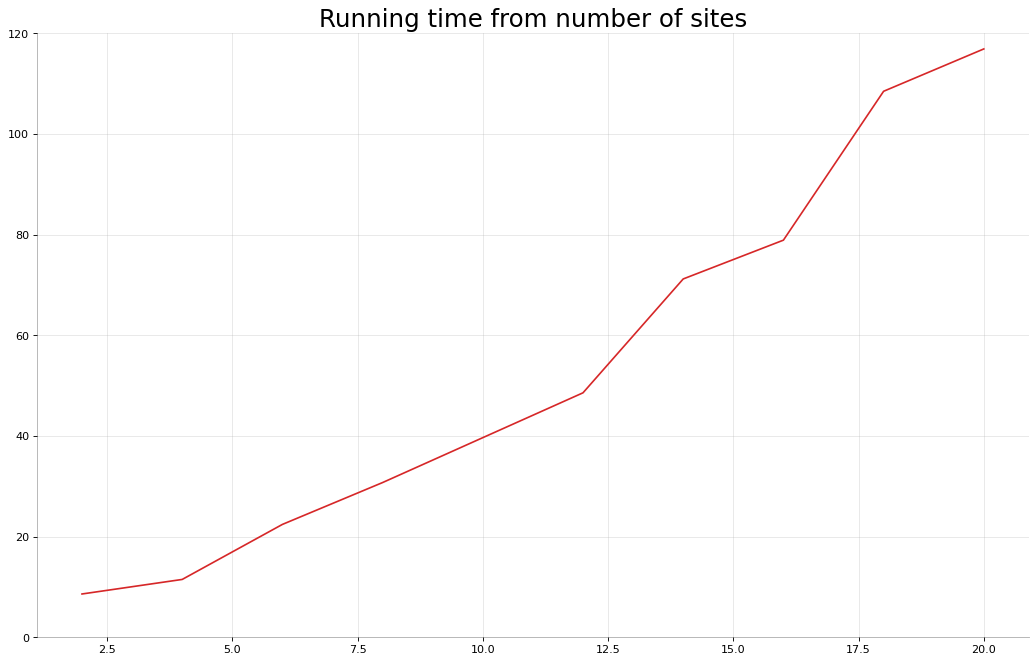

In [ ]:
plt.figure(figsize=(16,10), dpi= 80)
plt.plot([2, 4, 6, 8, 10, 12, 14, 16, 18, 20], et, color='tab:red')
plt.title("Running time from number of sites", fontsize=22)
plt.grid(axis='both', alpha=.3)
plt.ylim(0, 120)
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3) 
plt.savefig('runtime.jpg')
plt.show()

In [22]:
def sim_opt(real_haplotypes, real_prevs, host_data, hl):
  start_time = time.time()

  prev_haps_init = np.random.uniform(size = samp_num + hap_num*hl)

  opt_prev_haps = optimise_haps_and_prevs(prev_haps_init, host_data, er_rate)


  for _ in range(6):
    opt_prev_haps = optimise_haps_and_prevs(opt_prev_haps, host_data)

  exec_time = time.time() - start_time
  print("time elapsed: {:.2f}s".format(exec_time))

  print('RESULT')
  print("opt_prevs:", opt_prev_haps[:samp_num])
  print("real_prevs:", real_prevs)
  print("opt_haps:", np.reshape(opt_prev_haps[samp_num:], (hap_num, -1)))
  print("real_haps:", real_haplotypes)

  if np.linalg.norm(opt_prev_haps[:samp_num] - real_prevs) < np.linalg.norm(opt_prev_haps[:samp_num] - (1. - real_prevs)):
    prev_acc = np.linalg.norm(opt_prev_haps[:samp_num] - real_prevs) / np.linalg.norm(real_prevs)
    o_haps = np.reshape(opt_prev_haps[samp_num:], (hap_num, -1))
    haps_acc = np.array([np.linalg.norm(o_haps[0] - real_haplotypes[0])/np.linalg.norm(real_haplotypes[0]), np.linalg.norm(o_haps[1] - real_haplotypes[1])/np.linalg.norm(real_haplotypes[1])])
  else:
    prev_acc = np.linalg.norm(opt_prev_haps[:samp_num] - (1. - real_prevs)) / np.linalg.norm(1. - real_prevs)
    o_haps = np.reshape(opt_prev_haps[samp_num:], (hap_num, -1))
    haps_acc = np.array([np.linalg.norm(o_haps[0] - real_haplotypes[1])/np.linalg.norm(real_haplotypes[1]), np.linalg.norm(o_haps[1] - real_haplotypes[0])/np.linalg.norm(real_haplotypes[0])])

  print("Evaluation error of prevalences:", prev_acc)
  print("Evaluation error of haplotypes:", haps_acc)
  
  return exec_time, prev_acc, haps_acc

In [31]:
e_time_sim = []
p_acc_sim = []
h_acс_sim = []
for sites in [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]:
  haps = np.ones((2, sites))
  haps[0][int(sites/2):]=0.
  haps[1][:int(sites/2)]=0.
  hap_len = len(haps[0])
  exec_time_sim = 0.
  prev_ac_sim = 0.
  haps_ac_sim = np.zeros(2)
  for j in range(10):
    exmp_prevs = Prevalence(samp_num, 0.3)
    patients_data = SimulateReads(haps, exmp_prevs, er_rate=0.)
    exec_time, prev_ac, haps_ac = sim_opt(haps, exmp_prevs, patients_data, hap_len)
    exec_time_sim += exec_time
    prev_ac_sim += prev_ac
    haps_ac_sim += haps_ac
  
  p_acc_sim.append(prev_ac_sim/10)
  h_acс_sim.append(haps_ac_sim/10)
  e_time_sim.append(exec_time_sim/10)
  
print("Runtime:", e_time_sim)
print("Eval prev error:", p_acc_sim)
print("Eval haps error:", h_acс_sim)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 9.68s
RESULT
opt_prevs: [1.49999869e-02 6.40000004e-01 1.99999993e-01 7.29999993e-01
 4.22854015e-09 6.99999993e-01 1.17379342e-08 2.94999992e-01
 9.99999996e-01 4.20000011e-01]
real_prevs: [0.98119745 0.37375157 0.7997526  0.33475529 0.97318357 0.25553146
 1.         0.71609583 0.         0.52894743]
opt_haps: [[7.92098591e-09 9.99999988e-01]
 [9.99999992e-01 1.31249479e-08]]
real_haps: [[1. 0.]
 [0. 1.]]
Evaluation error of prevalences: 0.05995558692118868
Evaluation error of haplotypes: [1.46274147e-08 1.53181917e-08]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 9.56s
RESULT
opt_prevs: [2.11615045e-09 7.04999988e-01 1.69999990e-01 1.09999986e-01
 9.99999986e-01 9.99999998e-01 6.29999988e-01 6.79999983e-01
 1.36202921e-08 4.99999883e-02]
real_prevs: [1.         0.29467764 0.86120804 0.86973944 0.         0.
 0.32092809 0.30898456 1.         0.9145291 ]
opt_haps: [[5.59581268e-10 9.99999992e-01]
 [9.99999986e-01 1.32355243e-08]]
real_haps: [[1. 0.]
 [0. 1.]]
Evaluation error of prevalences: 0.03855368663024869
Evaluation error of haplotypes: [8.00550500e-09 1.93811157e-08]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 8.87s
RESULT
opt_prevs: [7.00000161e-02 3.11622077e-08 5.00001190e-03 9.75000069e-01
 3.10207630e-08 2.11716690e-08 2.95293416e-08 9.99999974e-01
 3.60000031e-01 9.60000087e-01]
real_prevs: [0.07648418 0.         0.01760676 0.96699834 0.         0.
 0.         1.         0.35770143 0.96469598]
opt_haps: [[9.99999964e-01 1.66328234e-07]
 [1.45256415e-08 9.99999989e-01]]
real_haps: [[1. 0.]
 [0. 1.]]
Evaluation error of prevalences: 0.009871730980796259
Evaluation error of haplotypes: [1.70089094e-07 1.83013579e-08]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 10.78s
RESULT
opt_prevs: [7.38475528e-09 1.35740541e-01 2.71558025e-01 8.46856381e-01
 3.94119940e-01 3.74978515e-01 5.30297195e-10 9.10253373e-01
 3.49154418e-01 4.91170996e-01]
real_prevs: [0.         0.12991224 0.20752198 0.6698347  0.33654048 0.32461999
 0.         0.71224711 0.23912121 0.41567982]
opt_haps: [[7.67232886e-01 2.19978877e-01]
 [3.94652794e-09 9.99999996e-01]]
real_haps: [[1. 0.]
 [0. 1.]]
Evaluation error of prevalences: 0.25912341429002433
Evaluation error of haplotypes: [3.20267444e-01 5.72886029e-09]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 9.43s
RESULT
opt_prevs: [3.24999985e-01 5.05000002e-01 9.14999981e-01 9.99999994e-01
 3.84999975e-01 4.99998550e-03 5.76972091e-09 3.30000001e-01
 3.99999874e-02 6.50141273e-09]
real_prevs: [0.63983016 0.44906699 0.11400989 0.         0.61684393 0.99777417
 1.         0.67306803 0.96546262 1.        ]
opt_haps: [[1.40919338e-08 9.99999986e-01]
 [9.99999995e-01 1.55516879e-08]]
real_haps: [[1. 0.]
 [0. 1.]]
Evaluation error of prevalences: 0.04139928821327786
Evaluation error of haplotypes: [1.96426225e-08 1.62021735e-08]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 9.11s
RESULT
opt_prevs: [6.64999992e-01 5.81153287e-09 9.99999991e-01 9.09999990e-01
 7.89999992e-01 6.59999988e-01 1.04999999e-01 3.30000002e-01
 5.84634528e-09 6.31571334e-09]
real_prevs: [0.68082047 0.         1.         0.91074019 0.78593353 0.66877504
 0.09689358 0.28745894 0.         0.        ]
opt_haps: [[9.99999984e-01 9.66597379e-09]
 [4.68778997e-09 9.99999996e-01]]
real_haps: [[1. 0.]
 [0. 1.]]
Evaluation error of prevalences: 0.025366130506596436
Evaluation error of haplotypes: [1.85986731e-08 6.00121998e-09]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 8.53s
RESULT
opt_prevs: [1.63820085e-08 6.85000024e-01 3.95000014e-01 9.99999996e-01
 4.20000027e-01 2.93903502e-08 3.95000024e-01 9.99999963e-01
 1.35000018e-01 5.00000240e-02]
real_prevs: [1.         0.2890517  0.65764211 0.         0.57084642 1.
 0.59675523 0.         0.88918512 0.94638276]
opt_haps: [[7.00507752e-08 9.99999921e-01]
 [9.99999994e-01 8.45580707e-09]]
real_haps: [[1. 0.]
 [0. 1.]]
Evaluation error of prevalences: 0.03748746354422817
Evaluation error of haplotypes: [1.05912706e-07 1.05306593e-08]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 9.05s
RESULT
opt_prevs: [8.03724911e-01 3.11199215e-01 9.99999964e-01 3.15848680e-01
 1.95219725e-01 9.99999963e-01 9.59895988e-08 5.01800995e-01
 9.69796689e-01 6.42406534e-01]
real_prevs: [0.83705425 0.3358347  1.         0.30539332 0.19747911 1.
 0.00495157 0.53172758 0.94279446 0.66348297]
opt_haps: [[9.99999971e-01 3.81737799e-08]
 [1.21974877e-07 9.86393181e-01]]
real_haps: [[1. 0.]
 [0. 1.]]
Evaluation error of prevalences: 0.02934872919636344
Evaluation error of haplotypes: [4.77950276e-08 1.36068189e-02]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 8.93s
RESULT
opt_prevs: [9.99999974e-01 3.17897842e-08 4.05000010e-01 8.65000023e-01
 8.25000023e-01 1.90000009e-01 1.99999997e-01 6.40000015e-01
 2.95682172e-08 2.53029505e-08]
real_prevs: [0.         1.         0.61868778 0.1227032  0.21451196 0.83348003
 0.82401558 0.40250334 1.         1.        ]
opt_haps: [[4.43106007e-08 9.99999933e-01]
 [9.99999984e-01 1.71058429e-08]]
real_haps: [[1. 0.]
 [0. 1.]]
Evaluation error of prevalences: 0.04203349657241067
Evaluation error of haplotypes: [8.00755505e-08 2.37484903e-08]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 8.57s
RESULT
opt_prevs: [1.04999948e-01 9.99999968e-01 2.49999947e-01 9.99999967e-01
 9.99999968e-01 3.94999949e-01 3.18277927e-08 8.49999984e-01
 5.79999985e-01 8.24999986e-01]
real_prevs: [0.84722072 0.         0.77092836 0.         0.         0.6165881
 1.         0.13698613 0.4124449  0.22094489]
opt_haps: [[1.93167221e-08 9.99999976e-01]
 [9.99999927e-01 5.79511619e-08]]
real_haps: [[1. 0.]
 [0. 1.]]
Evaluation error of prevalences: 0.03248754163618418
Evaluation error of haplotypes: [3.06320582e-08 9.32881568e-08]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 12.27s
RESULT
opt_prevs: [1.85422030e-07 9.99999908e-01 9.99999996e-01 2.17480440e-01
 9.99999814e-01 4.57500207e-01 4.92499404e-01 1.85958535e-07
 9.99999815e-01 2.35009461e-01]
real_prevs: [0.         1.         1.         0.17548867 1.         0.45121404
 0.46238128 0.         1.         0.26989935]
opt_haps: [[9.99999834e-01 9.99999811e-01 1.86009016e-07 3.07028458e-09]
 [8.17196294e-08 3.30458671e-07 9.99999655e-01 9.99999521e-01]]
real_haps: [[1. 1. 0. 0.]
 [0. 0. 1. 1.]]
Evaluation error of prevalences: 0.02947300198951424
Evaluation error of haplotypes: [2.21571845e-07 4.81518908e-07]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 13.34s
RESULT
opt_prevs: [1.87974498e-09 3.62499999e-01 4.02499987e-01 7.35000023e-01
 9.99999998e-01 9.85000046e-01 4.10614444e-09 1.12499984e-01
 9.67500014e-01 6.09999996e-01]
real_prevs: [0.         0.38960769 0.36525543 0.71640807 1.         0.98780595
 0.         0.1030423  0.95268215 0.61467856]
opt_haps: [[9.99999919e-01 9.99999988e-01 9.79203563e-09 1.66878563e-08]
 [7.67423506e-09 8.95590323e-09 9.99999996e-01 9.99999992e-01]]
real_haps: [[1. 1. 0. 0.]
 [0. 0. 1. 1.]]
Evaluation error of prevalences: 0.02625824062489554
Evaluation error of haplotypes: [5.97499670e-08 1.04159769e-08]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 13.16s
RESULT
opt_prevs: [6.72499994e-01 9.24999998e-01 9.99999997e-01 8.37499989e-01
 5.24999686e-02 3.57499989e-01 3.39999981e-01 4.73442938e-09
 5.32499991e-01 7.94999997e-01]
real_prevs: [0.30433802 0.07870189 0.         0.15435967 0.94928832 0.65063107
 0.65626845 1.         0.49524248 0.17940312]
opt_haps: [[4.02080938e-09 7.08398237e-10 9.99999976e-01 9.99999985e-01]
 [9.99999979e-01 9.99999955e-01 6.64137631e-09 1.12015079e-08]]
real_haps: [[1. 1. 0. 0.]
 [0. 0. 1. 1.]]
Evaluation error of prevalences: 0.022440762707185074
Evaluation error of haplotypes: [2.02427607e-08 3.66189388e-08]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 13.58s
RESULT
opt_prevs: [1.94999993e-01 4.27438654e-09 9.47499999e-01 4.35178477e-09
 9.99999997e-01 2.29999989e-01 5.32500000e-01 1.02499990e-01
 1.04999992e-01 7.89999993e-01]
real_prevs: [0.23225432 0.         0.9349009  0.         1.         0.26421598
 0.57165717 0.09135462 0.09948411 0.78843298]
opt_haps: [[9.99999994e-01 9.99999985e-01 1.10542130e-08 1.42815668e-08]
 [6.60457381e-09 7.82425749e-09 9.99999996e-01 9.99999992e-01]]
real_haps: [[1. 1. 0. 0.]
 [0. 0. 1. 1.]]
Evaluation error of prevalences: 0.03855988143690034
Evaluation error of haplotypes: [1.74282865e-08 9.69755558e-09]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 14.61s
RESULT
opt_prevs: [0.13760715 1.         0.74607058 0.67628564 0.61126638 0.00563448
 0.31654805 0.53874928 1.         0.90154842]
real_prevs: [0.85301478 0.         0.23557764 0.31839948 0.36736143 0.95247003
 0.6657107  0.43533323 0.         0.11034309]
opt_haps: [[5.27079548e-09 6.44601678e-09 9.99999994e-01 9.99999994e-01]
 [9.79302834e-01 9.73794779e-01 5.61315654e-02 3.66442819e-02]]
real_haps: [[1. 1. 0. 0.]
 [0. 0. 1. 1.]]
Evaluation error of prevalences: 0.028422415139861035
Evaluation error of haplotypes: [8.63112175e-09 5.29558418e-02]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 16.88s
RESULT
opt_prevs: [9.88436151e-01 4.25307288e-02 5.17861013e-01 9.99999981e-01
 1.94534174e-08 6.98023345e-01 9.96165772e-01 3.37772872e-01
 4.55345350e-01 6.77980419e-01]
real_prevs: [0.03134567 0.96373968 0.50141559 0.         1.         0.28003571
 0.00479739 0.71634644 0.50054697 0.33255435]
opt_haps: [[3.14723763e-08 2.69501479e-03 9.99778191e-01 9.99999956e-01]
 [9.99999994e-01 9.99999928e-01 6.54495862e-08 5.98422101e-08]]
real_haps: [[1. 1. 0. 0.]
 [0. 0. 1. 1.]]
Evaluation error of prevalences: 0.037442308133915164
Evaluation error of haplotypes: [1.91210668e-03 8.10699267e-08]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 13.53s
RESULT
opt_prevs: [9.17500001e-01 2.99999783e-02 7.49999763e-02 4.52499993e-01
 8.37500001e-01 6.69999991e-01 5.79999996e-01 9.99999997e-01
 3.85435510e-09 3.07499993e-01]
real_prevs: [0.91812958 0.02894031 0.08097508 0.44650989 0.8299904  0.66857002
 0.53652408 1.         0.         0.30176015]
opt_haps: [[9.99999974e-01 9.99999985e-01 1.02441040e-08 7.80726919e-09]
 [1.26701143e-08 3.70690357e-08 9.99999991e-01 9.99999988e-01]]
real_haps: [[1. 1. 0. 0.]
 [0. 0. 1. 1.]]
Evaluation error of prevalences: 0.02400866043050573
Evaluation error of haplotypes: [2.31732000e-08 2.97173306e-08]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 14.01s
RESULT
opt_prevs: [1.36990115e-10 8.94534866e-01 1.40740253e-01 5.50020160e-01
 9.88238715e-01 1.90357834e-01 7.75135677e-09 7.75184190e-09
 1.72134002e-01 5.49782592e-01]
real_prevs: [1.         0.15816635 0.85397978 0.45244109 0.05676131 0.8288995
 1.         1.         0.80901856 0.46347331]
opt_haps: [[4.67561084e-02 2.34061938e-02 9.46719616e-01 9.59073773e-01]
 [9.99999992e-01 9.99999990e-01 1.14443931e-08 9.53630430e-09]]
real_haps: [[1. 1. 0. 0.]
 [0. 0. 1. 1.]]
Evaluation error of prevalences: 0.05024271021928965
Evaluation error of haplotypes: [6.01985835e-02 1.41831228e-08]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 13.58s
RESULT
opt_prevs: [6.84032001e-08 1.37493105e-01 7.52516118e-01 9.99999840e-01
 9.99999854e-01 9.99999990e-01 8.34988773e-01 3.22496627e-01
 4.92503509e-01 7.37497339e-01]
real_prevs: [0.         0.10423087 0.71911102 1.         1.         1.
 0.81178841 0.37267938 0.47481976 0.7724693 ]
opt_haps: [[9.99999759e-01 9.99999838e-01 3.73092633e-09 1.45143254e-07]
 [7.15672621e-07 4.72416292e-07 9.99999458e-01 9.99999002e-01]]
real_haps: [[1. 1. 0. 0.]
 [0. 0. 1. 1.]]
Evaluation error of prevalences: 0.0363830576329329
Evaluation error of haplotypes: [2.29307453e-07 1.00645773e-06]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 12.61s
RESULT
opt_prevs: [4.42500013e-01 9.99999983e-01 8.45000033e-01 6.05000009e-01
 2.10780273e-08 7.24999901e-02 3.65000002e-01 1.38558790e-08
 7.80000031e-01 2.39864425e-08]
real_prevs: [0.5653836  0.         0.16366873 0.40088804 1.         0.91647556
 0.65598378 1.         0.20270341 1.        ]
opt_haps: [[1.05460015e-07 1.15394527e-08 9.99999963e-01 9.99999912e-01]
 [9.99999983e-01 9.99999971e-01 3.11000790e-08 1.64062942e-08]]
real_haps: [[1. 1. 0. 0.]
 [0. 0. 1. 1.]]
Evaluation error of prevalences: 0.018530626477834062
Evaluation error of haplotypes: [1.01076688e-07 3.43541064e-08]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 18.11s
RESULT
opt_prevs: [9.93466177e-09 4.74999963e-01 8.84999988e-01 9.99999990e-01
 5.86666642e-01 8.41666658e-01 6.68333299e-01 9.99999991e-01
 6.31666636e-01 9.99999988e-01]
real_prevs: [1.         0.5455885  0.1212351  0.         0.43277165 0.13957596
 0.35831361 0.         0.38353957 0.        ]
opt_haps: [[2.09574837e-08 1.55159812e-08 2.24882164e-08 9.99999998e-01
  9.99999981e-01 9.99999983e-01]
 [9.99999949e-01 9.99999929e-01 9.99999896e-01 5.89546245e-08
  6.85262512e-08 5.47005803e-08]]
real_haps: [[1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1.]]
Evaluation error of prevalences: 0.01912668714807915
Evaluation error of haplotypes: [2.49169807e-08 9.93514269e-08]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 17.35s
RESULT
opt_prevs: [5.57085240e-09 4.56782651e-09 9.99999997e-01 9.99999998e-01
 2.99999674e-02 1.91747486e-09 6.18338620e-01 3.85003119e-01
 6.10014427e-01 6.08336069e-01]
real_prevs: [1.         1.         0.         0.         0.97544184 1.
 0.36935237 0.597908   0.39550388 0.36255669]
opt_haps: [[1.04767692e-08 1.87629751e-08 1.63494666e-08 9.99999986e-01
  9.99999992e-01 9.99999987e-01]
 [1.00000000e+00 9.99999991e-01 9.99999994e-01 1.14473560e-08
  4.55371112e-09 7.78911764e-09]]
real_haps: [[1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1.]]
Evaluation error of prevalences: 0.020135649326506015
Evaluation error of haplotypes: [1.97027978e-08 1.06452716e-08]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 18.51s
RESULT
opt_prevs: [3.44999996e-01 2.68333328e-01 6.18333328e-01 2.13751429e-09
 3.06293163e-09 5.16666662e-01 9.99999997e-01 6.63333334e-01
 6.53333334e-01 1.41666659e-01]
real_prevs: [0.38733374 0.262518   0.63992975 0.         0.         0.52736397
 1.         0.65240205 0.61698689 0.13511503]
opt_haps: [[9.99999986e-01 9.99999978e-01 9.99999985e-01 1.65419035e-08
  1.23220103e-08 1.15130052e-08]
 [1.10428968e-08 4.04527889e-10 2.16670717e-09 9.99999993e-01
  9.99999993e-01 9.99999992e-01]]
real_haps: [[1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1.]]
Evaluation error of prevalences: 0.03774156670720792
Evaluation error of haplotypes: [2.20148399e-08 9.76746251e-09]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 19.14s
RESULT
opt_prevs: [1.09999951e-01 9.03333382e-01 3.73333316e-01 5.76666674e-01
 3.31666644e-01 6.40000020e-01 1.43333287e-01 9.99999988e-01
 1.06307948e-08 5.50000003e-01]
real_prevs: [0.1098034  0.89637207 0.35453087 0.62400352 0.34176403 0.65103191
 0.16465319 1.         0.         0.53473789]
opt_haps: [[9.99999869e-01 9.99999954e-01 9.99999937e-01 5.21829839e-08
  8.68344935e-08 6.28814959e-08]
 [8.51872782e-08 4.98506303e-08 8.26137424e-08 9.99999940e-01
  9.99999957e-01 9.99999933e-01]]
real_haps: [[1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1.]]
Evaluation error of prevalences: 0.033407735476498224
Evaluation error of haplotypes: [1.11704151e-07 9.38487448e-08]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 18.62s
RESULT
opt_prevs: [5.26666655e-01 9.99999999e-01 3.34999986e-01 1.82719602e-09
 2.96666650e-01 6.54999995e-01 7.46666664e-01 5.01666657e-01
 4.86666656e-01 6.86666665e-01]
real_prevs: [0.45816562 0.         0.66108462 1.         0.70589722 0.36905716
 0.27274066 0.51787632 0.48425997 0.28790547]
opt_haps: [[2.01921185e-08 9.41628667e-09 8.51621059e-09 9.99999987e-01
  9.99999990e-01 9.99999990e-01]
 [9.99999986e-01 9.99999982e-01 9.99999985e-01 1.11399517e-08
  1.96014692e-08 2.37949108e-08]]
real_haps: [[1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1.]]
Evaluation error of prevalences: 0.029982562349199333
Evaluation error of haplotypes: [1.74866820e-08 2.44761334e-08]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 19.39s
RESULT
opt_prevs: [2.24975638e-09 9.84462484e-01 1.49322768e-01 5.22734498e-01
 5.82458231e-02 2.57711797e-09 5.21719983e-01 4.72477696e-01
 1.94929062e-09 8.32243175e-01]
real_prevs: [1.         0.10861317 0.84425574 0.52432835 0.94527604 1.
 0.54607902 0.60643236 1.         0.25498957]
opt_haps: [[1.26064790e-01 8.72690815e-02 6.90696837e-02 9.45003103e-01
  9.35307315e-01 8.95840370e-01]
 [9.99999996e-01 9.99999994e-01 9.99999996e-01 4.62244568e-09
  3.05332135e-09 5.35026782e-09]]
real_haps: [[1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1.]]
Evaluation error of prevalences: 0.1222741633371423
Evaluation error of haplotypes: [1.24281771e-01 6.49997387e-09]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 19.20s
RESULT
opt_prevs: [2.41154873e-01 8.99179471e-01 1.18486433e-08 7.22593063e-02
 9.99999988e-01 5.07620296e-03 2.47815847e-01 9.74696096e-01
 6.16164084e-01 9.97315035e-01]
real_prevs: [0.25645473 0.9033382  0.         0.06328859 1.         0.00211581
 0.2635596  0.97272704 0.61554282 0.98686161]
opt_haps: [[9.93479319e-01 9.90943206e-01 9.99999970e-01 2.06730660e-03
  3.58191704e-08 4.30383270e-08]
 [3.89719141e-08 6.64058033e-06 9.64213201e-03 9.99999968e-01
  9.99999736e-01 9.99999957e-01]]
real_haps: [[1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1.]]
Evaluation error of prevalences: 0.012845875036422318
Evaluation error of haplotypes: [0.00655283 0.00556689]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 16.18s
RESULT
opt_prevs: [ 3.69187934e-03  1.01061540e+00  5.45474458e-01  4.19890672e-01
  7.95791238e-01  3.25252908e-02  9.71364874e-01 -1.03804307e-04
  2.40097326e-01  6.27318939e-02]
real_prevs: [0.80232568 0.         0.29851116 0.30676139 0.14032    0.72316262
 0.03388457 0.84358249 0.48177319 0.6481772 ]
opt_haps: [[0.02524538 0.01630938 0.00830882 0.98178415 0.9816886  0.986909  ]
 [0.71112748 0.690369   0.73067192 0.25850537 0.26208278 0.23222306]]
real_haps: [[1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1.]]
Evaluation error of prevalences: 0.3039800417082168
Evaluation error of haplotypes: [0.02456868 0.38353455]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 16.77s
RESULT
opt_prevs: [9.99999997e-01 9.66666670e-01 2.78333310e-01 1.38338303e-08
 1.51666645e-01 9.99999986e-01 1.38963736e-08 5.49999692e-02
 1.48333300e-01 9.99999996e-01]
real_prevs: [1.         0.96743001 0.2912992  0.         0.15176366 1.
 0.         0.0535701  0.14626337 1.        ]
opt_haps: [[9.99999973e-01 9.99999970e-01 9.99999990e-01 2.42458032e-08
  3.27787366e-08 1.65856024e-08]
 [3.38199314e-08 3.12404104e-08 1.02179205e-08 9.99999945e-01
  9.99999964e-01 9.99999970e-01]]
real_haps: [[1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1.]]
Evaluation error of prevalences: 0.006559471581462638
Evaluation error of haplotypes: [3.50073987e-08 5.00651928e-08]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 17.23s
RESULT
opt_prevs: [9.99999991e-01 1.10334856e-08 9.99999988e-01 1.25006267e-08
 8.18333345e-01 8.81666683e-01 7.63333342e-01 3.16666465e-02
 9.74252053e-09 5.19999998e-01]
real_prevs: [0.         1.         0.         1.         0.19136435 0.13894559
 0.22581158 0.97746198 1.         0.51784053]
opt_haps: [[3.03280028e-08 2.76339125e-08 3.19186967e-08 9.99999957e-01
  9.99999973e-01 9.99999961e-01]
 [9.99999975e-01 9.99999978e-01 9.99999973e-01 1.54236036e-08
  1.93551459e-08 1.93460837e-08]]
real_haps: [[1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1.]]
Evaluation error of prevalences: 0.02256156710912535
Evaluation error of haplotypes: [4.78685456e-08 3.07807996e-08]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 25.05s
RESULT
opt_prevs: [9.99999996e-01 1.09775629e-01 3.68865965e-01 8.14689545e-01
 8.99846183e-01 1.21064897e-01 8.14656479e-02 7.59729793e-09
 7.38299670e-02 5.34163962e-01]
real_prevs: [0.         0.88457996 0.64455847 0.20324636 0.10804155 0.9039892
 0.93210314 1.         0.93412646 0.46270272]
opt_haps: [[4.94492431e-08 6.04216585e-08 4.87772045e-08 9.49115616e-08
  9.99999938e-01 9.99999935e-01 9.99999963e-01 9.99999904e-01]
 [9.99999926e-01 9.99999955e-01 9.99999943e-01 9.99999959e-01
  4.44211030e-08 4.04832870e-08 1.23042667e-02 7.00780256e-08]]
real_haps: [[1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.022688364494515903
Evaluation error of haplotypes: [9.51170416e-08 6.15213335e-03]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 23.00s
RESULT
opt_prevs: [9.99999995e-01 7.13091136e-09 2.89999998e-01 4.23750009e-01
 1.07499985e-01 9.87500087e-01 6.46250033e-01 6.91923205e-09
 4.85000013e-01 4.55000021e-01]
real_prevs: [1.         0.         0.28215252 0.43068368 0.1226583  0.98378262
 0.66396248 0.         0.50095503 0.42733524]
opt_haps: [[9.99999975e-01 9.99999933e-01 9.99999905e-01 9.99999950e-01
  3.36902823e-08 1.23466433e-07 2.05451853e-07 4.77804793e-08]
 [2.91780356e-08 2.01172206e-08 3.12653626e-08 3.04748799e-08
  9.99999971e-01 9.99999975e-01 9.99999972e-01 9.99999998e-01]]
real_haps: [[1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.023243384434383434
Evaluation error of haplotypes: [1.39222307e-07 3.67328716e-08]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 19.69s
RESULT
opt_prevs: [ 1.10583958  0.86444491  0.44916764  0.53092895  0.66504756  0.12119284
  0.36194955  1.14044498 -0.12100068  0.03190561]
real_prevs: [0.         0.18364871 0.5764368  0.48580091 0.31551292 0.89291301
 0.68792735 0.         1.         0.97028747]
opt_haps: [[0.3042107  0.2758355  0.16791683 0.19173005 0.84793375 0.85363012
  0.87029051 0.72919844]
 [0.84712731 0.86084721 0.86581262 0.77828911 0.13827407 0.10206369
  0.21365784 0.20253891]]
real_haps: [[1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.11860406672191193
Evaluation error of haplotypes: [0.3034354  0.23775194]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 28.92s
RESULT
opt_prevs: [8.80862441e-01 7.63086235e-01 9.77107107e-01 2.05964162e-01
 2.45716724e-09 6.18625640e-10 2.69524618e-09 2.73562584e-01
 2.64762033e-01 1.19035253e-01]
real_prevs: [0.25539194 0.36830245 0.15515899 0.79636766 1.         1.
 1.         0.77546583 0.79550223 0.9136871 ]
opt_haps: [[1.89531135e-01 1.09846252e-01 1.44917684e-01 1.43013668e-01
  9.06839852e-01 7.99461746e-01 8.46011579e-01 8.33484913e-01]
 [9.99999993e-01 9.99999998e-01 9.99999995e-01 9.99999993e-01
  6.80031703e-09 5.32602155e-09 1.19516626e-09 4.87556766e-09]]
real_haps: [[1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.18280822611689052
Evaluation error of haplotypes: [2.17816670e-01 7.52832319e-09]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 31.70s
RESULT
opt_prevs: [6.58073333e-01 7.36643775e-08 5.94259990e-08 4.72698400e-08
 3.98303873e-01 9.28784429e-01 8.99017562e-03 6.62920484e-01
 2.69847028e-02 6.77407248e-08]
real_prevs: [0.63915345 1.         1.         1.         0.76778477 0.46713914
 0.99320538 0.60952604 0.98512085 1.        ]
opt_haps: [[4.01881127e-01 4.81578938e-01 4.78552671e-01 4.78684030e-01
  5.88638790e-01 6.14244263e-01 5.45883303e-01 5.40479070e-01]
 [9.99999874e-01 9.99999876e-01 9.99999938e-01 9.99999926e-01
  1.16141399e-07 1.16911407e-07 1.40603260e-07 6.44777274e-08]]
real_haps: [[1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.7476943304778961
Evaluation error of haplotypes: [6.29877918e-01 1.51350826e-07]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 21.30s
RESULT
opt_prevs: [ 0.53131948  0.45936386  0.45543299 -0.22665539 -0.2400978   1.08377117
  1.04663956  0.16629339  0.64646588  0.84348421]
real_prevs: [0.38135441 0.49541806 0.49623858 1.         1.         0.00513756
 0.03268547 0.77298047 0.22391319 0.11295117]
opt_haps: [[0.11645147 0.08072842 0.07751101 0.11565676 0.84580088 0.87201295
  0.83750384 0.88999016]
 [0.77514452 0.74290523 0.80768766 0.74072832 0.26021245 0.2707035
  0.27731423 0.27833699]]
real_haps: [[1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.19240984289881607
Evaluation error of haplotypes: [0.17184854 0.35924543]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 25.82s
RESULT
opt_prevs: [5.97500025e-01 1.79999997e-01 8.05000020e-01 8.27500037e-01
 2.89999996e-01 5.53750024e-01 9.99999990e-01 1.03954501e-08
 7.35186819e-09 8.96250047e-01]
real_prevs: [0.61258719 0.18742019 0.80363448 0.81374101 0.27527614 0.54862762
 1.         0.         0.         0.88786494]
opt_haps: [[9.99999932e-01 9.99999875e-01 9.99999916e-01 9.99999914e-01
  4.86986583e-08 1.19779736e-07 6.87769460e-08 2.61655092e-08]
 [4.14096715e-08 3.78509743e-08 2.30125835e-08 1.50456118e-08
  9.99999950e-01 9.99999976e-01 9.99999993e-01 9.99999955e-01]]
real_haps: [[1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.014237454858106733
Evaluation error of haplotypes: [1.19124327e-07 4.76306338e-08]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 20.32s
RESULT
opt_prevs: [7.92499994e-01 1.93329152e-09 4.77499992e-01 4.96249995e-01
 9.99999999e-01 2.52136973e-09 8.51249994e-01 9.99999998e-01
 9.99999999e-01 6.05997102e-10]
real_prevs: [0.23190719 1.         0.51630765 0.49996319 0.         1.
 0.13975455 0.         0.         1.        ]
opt_haps: [[8.12329942e-09 6.31685388e-09 7.82744026e-09 6.01452703e-09
  9.99999996e-01 9.99999994e-01 9.99999998e-01 9.99999995e-01]
 [9.99999998e-01 9.99999995e-01 9.99999994e-01 9.99999995e-01
  3.05140533e-09 2.76048473e-09 5.56709394e-09 6.22884678e-09]]
real_haps: [[1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.012308497745183538
Evaluation error of haplotypes: [8.40972983e-09 6.57949887e-09]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 29.51s
RESULT
opt_prevs: [ 0.84770587 -0.01686425  0.02570075  0.17174816  0.99259867  0.46468918
  0.63517701  0.22111513  0.55704142  0.85533103]
real_prevs: [0.2413734  0.99450904 0.9385074  0.84681643 0.11789617 0.57470984
 0.44040998 0.76770147 0.5265475  0.23812262]
opt_haps: [[0.12011053 0.12781331 0.15626514 0.16124506 0.86487329 0.85687306
  0.90184219 0.86245816]
 [0.94641153 0.95034474 0.98167961 0.97395208 0.01971577 0.03896167
  0.01931316 0.02284591]]
real_haps: [[1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.12884839305393597
Evaluation error of haplotypes: [0.19266474 0.04783606]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 20.08s
RESULT
opt_prevs: [7.75245931e-01 9.99509326e-01 2.19546940e-03 7.90951484e-01
 3.46548095e-04 9.99453465e-01 9.99587588e-01 9.99671344e-01
 1.81458606e-05 8.21763611e-03]
real_prevs: [0.57867511 0.96772997 0.0112706  0.61168697 0.00206275 0.94295293
 0.93377486 0.67190731 0.         0.01363396]
opt_haps: [[8.23780197e-01 7.69223579e-01 7.95845989e-01 8.17007799e-01
  1.33065551e-01 1.70704257e-01 1.49553997e-01 2.04485172e-01]
 [9.60924019e-03 2.06621476e-02 3.33023125e-03 1.64902715e-04
  9.99744756e-01 9.98279427e-01 9.95811642e-01 9.99622630e-01]]
real_haps: [[1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.2200628821435301
Evaluation error of haplotypes: [0.26004959 0.01173765]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 25.26s
RESULT
opt_prevs: [5.03000316e-01 9.99999997e-01 2.81999585e-01 9.99999998e-01
 3.22052088e-09 3.11021390e-09 3.09785280e-09 3.05378803e-09
 3.53001803e-01 9.99999998e-01]
real_prevs: [0.54345361 0.         0.71190848 0.         1.         1.
 1.         1.         0.66971487 0.        ]
opt_haps: [[7.03506211e-09 1.00429917e-08 1.01401621e-08 4.71354846e-09
  1.93519293e-10 9.99999990e-01 9.99999990e-01 9.99999990e-01
  9.99999994e-01 9.99999992e-01]
 [9.99999992e-01 9.99999995e-01 9.99999992e-01 9.99999992e-01
  9.99999995e-01 4.13197339e-10 7.32456566e-09 2.85183276e-09
  7.65737840e-09 7.50464907e-09]]
real_haps: [[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.02823593875107002
Evaluation error of haplotypes: [1.17932039e-08 9.10883263e-09]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 26.66s
RESULT
opt_prevs: [6.54170796e-09 6.99586974e-09 5.24353714e-01 1.44097611e-01
 9.54084809e-01 7.75784279e-09 4.45838044e-09 8.67944087e-09
 8.91721296e-01 9.99999996e-01]
real_prevs: [1.         1.         0.48243811 0.88502428 0.05629994 1.
 1.         1.         0.10473842 0.        ]
opt_haps: [[5.29083746e-08 6.42332365e-08 6.47672150e-08 1.42068642e-07
  9.96586003e-08 9.93404672e-01 9.99999962e-01 9.99999908e-01
  9.99999968e-01 9.99999922e-01]
 [9.99999991e-01 9.99999984e-01 9.99999992e-01 9.99999991e-01
  9.99999982e-01 1.07786378e-08 1.03172267e-08 1.07265405e-08
  1.55682499e-08 1.19890070e-08]]
real_haps: [[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.018472964749603537
Evaluation error of haplotypes: [2.94952045e-03 1.74028994e-08]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 37.70s
RESULT
opt_prevs: [0.46451302 0.92022273 0.01396436 0.75869763 1.         0.37775765
 1.         0.70771733 0.16722617 1.        ]
real_prevs: [0.46537591 0.07086444 0.87219061 0.20709648 0.         0.5457112
 0.         0.25193478 0.71050709 0.        ]
opt_haps: [[3.38609469e-09 4.69293301e-09 5.06066357e-09 3.70822601e-09
  4.41763468e-09 9.99999997e-01 9.99999994e-01 9.99999996e-01
  9.99999995e-01 9.99999996e-01]
 [8.50292091e-01 8.63540232e-01 8.39625484e-01 8.76068373e-01
  8.66448627e-01 1.88221986e-01 1.38496229e-01 1.58774810e-01
  8.98881857e-02 6.84259770e-02]]
real_haps: [[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.0858116169115967
Evaluation error of haplotypes: [6.11431728e-09 1.96228893e-01]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 26.25s
RESULT
opt_prevs: [0.04674041 0.9944039  0.4230562  0.00588018 0.99469411 0.89419466
 0.55405736 0.99409179 0.36382219 0.32761805]
real_prevs: [0.06732859 1.         0.56456739 0.         1.         0.90575698
 0.62685048 1.         0.49141772 0.42275084]
opt_haps: [[0.99327865 0.99337052 0.99323268 0.99327306 0.99224079 0.00646219
  0.00825104 0.00660819 0.00820026 0.00696019]
 [0.04687446 0.02853268 0.08495837 0.0448332  0.05539145 0.93762625
  0.95726893 0.97511281 0.95876754 0.94959159]]
real_haps: [[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.1017732011953999
Evaluation error of haplotypes: [0.01009531 0.07195055]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 36.99s
RESULT
opt_prevs: [0.22353514 0.07681563 0.31181566 0.05353593 0.28560814 1.
 0.02916308 0.8637383  1.         0.51808149]
real_prevs: [0.32949754 0.23139055 0.42854422 0.19452169 0.41582633 1.
 0.18956792 0.88045846 1.         0.60391905]
opt_haps: [[9.99999994e-01 9.99999994e-01 9.99999994e-01 9.99999994e-01
  9.99999994e-01 5.52617032e-09 6.07558548e-09 9.91835214e-09
  6.61523332e-09 6.73578823e-09]
 [1.79578828e-01 1.69553604e-01 1.96784497e-01 1.60134341e-01
  1.36450184e-01 8.56728123e-01 8.42725998e-01 8.59627705e-01
  8.13632016e-01 8.36349100e-01]]
real_haps: [[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.17852727988719336
Evaluation error of haplotypes: [9.33145208e-09 2.32578479e-01]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 27.31s
RESULT
opt_prevs: [7.16907557e-09 9.99999996e-01 8.29258473e-09 5.00000004e-01
 6.95603908e-09 1.37999988e-01 8.40000034e-01 2.94999999e-01
 4.73711341e-09 7.09999857e-02]
real_prevs: [0.         1.         0.         0.50843571 0.         0.14886957
 0.84592594 0.27770339 0.         0.06751959]
opt_haps: [[9.99999964e-01 9.99999916e-01 9.99999920e-01 9.99999976e-01
  9.99999927e-01 3.86468441e-08 8.70703035e-08 7.12943358e-08
  2.55300736e-08 6.28549629e-08]
 [1.73609015e-08 2.32800621e-08 2.27746036e-08 1.65591569e-08
  1.29629945e-08 9.99999991e-01 9.99999978e-01 9.99999984e-01
  9.99999981e-01 9.99999982e-01]]
real_haps: [[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.01605643622525618
Evaluation error of haplotypes: [8.88302075e-08 2.57898391e-08]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 27.57s
RESULT
opt_prevs: [9.99999998e-01 3.57997493e-01 6.83998834e-01 9.99999999e-01
 4.33997370e-01 1.69929880e-09 1.73764902e-09 9.99999998e-01
 4.15001296e-01 8.79000034e-01]
real_prevs: [0.         0.65731271 0.30055099 0.         0.57097504 1.
 1.         0.         0.59727937 0.12634933]
opt_haps: [[4.75064983e-09 4.72325042e-09 4.94014677e-09 4.81903626e-09
  5.86837349e-09 9.99999994e-01 9.99999994e-01 9.99999994e-01
  9.99999995e-01 9.99999993e-01]
 [1.00000000e+00 9.99999992e-01 9.99999993e-01 9.99999990e-01
  9.99999992e-01 7.91520594e-09 8.26249238e-09 6.47065589e-09
  9.52072119e-09 6.07949015e-09]]
real_haps: [[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.011983523236613428
Evaluation error of haplotypes: [8.01719011e-09 1.07726484e-08]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 29.54s
RESULT
opt_prevs: [9.99999998e-01 6.98999997e-01 8.75000001e-01 3.06999980e-01
 3.89999988e-01 6.26999989e-01 2.31208769e-09 1.37999980e-01
 4.92999988e-01 6.50999996e-01]
real_prevs: [0.         0.29387337 0.13114618 0.68163788 0.61725092 0.38133622
 1.         0.84852535 0.52748753 0.3420694 ]
opt_haps: [[2.13571017e-08 1.39481445e-08 4.08800323e-08 1.58852198e-08
  1.25043245e-09 9.99999990e-01 9.99999996e-01 9.99999993e-01
  9.99999992e-01 9.99999988e-01]
 [9.99999986e-01 9.99999966e-01 9.99999980e-01 9.99999983e-01
  9.99999996e-01 1.88570713e-08 1.11674646e-08 1.65803799e-08
  1.77232688e-08 2.17698224e-08]]
real_haps: [[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.01666069095795296
Evaluation error of haplotypes: [2.42694808e-08 2.68038058e-08]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 39.29s
RESULT
opt_prevs: [9.64061515e-01 7.61064841e-01 7.75695774e-09 8.14012225e-09
 2.55989372e-01 5.57231143e-01 2.09617047e-01 1.15646129e-08
 5.75139444e-01 5.42913957e-01]
real_prevs: [0.74133623 0.57380715 0.         0.         0.19780762 0.38812121
 0.16880015 0.         0.44948732 0.41677019]
opt_haps: [[8.00382894e-01 6.80912553e-01 7.24785420e-01 7.92638554e-01
  7.99159142e-01 2.63616832e-01 3.13812035e-01 2.42111405e-01
  2.20051945e-01 2.27165655e-01]
 [2.02722143e-08 2.14779924e-08 2.31389646e-08 1.87308122e-08
  2.24013013e-08 9.99999978e-01 9.99999979e-01 9.99999979e-01
  9.99999978e-01 9.99999981e-01]]
real_haps: [[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.3191546796948322
Evaluation error of haplotypes: [3.54220137e-01 2.98571161e-08]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 28.34s
RESULT
opt_prevs: [1.41999990e-01 6.45132568e-09 6.46365898e-09 6.65000034e-01
 3.66000007e-01 7.39000046e-01 7.70000049e-01 8.20000051e-01
 9.99999994e-01 6.45723459e-09]
real_prevs: [0.18331945 0.         0.         0.66329821 0.34488986 0.74176367
 0.76582514 0.81527143 1.         0.        ]
opt_haps: [[9.99999961e-01 9.99999905e-01 9.99999956e-01 9.99999949e-01
  9.99999906e-01 1.32697141e-07 1.23315991e-07 4.57226473e-08
  4.83264602e-08 9.62697124e-08]
 [2.28818356e-08 2.00275783e-08 2.24360655e-08 2.40883158e-08
  1.91113122e-08 9.99999983e-01 9.99999980e-01 9.99999978e-01
  9.99999976e-01 9.99999979e-01]]
real_haps: [[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.02547909621240978
Evaluation error of haplotypes: [1.18609796e-07 3.02725222e-08]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 36.45s
RESULT
opt_prevs: [9.99999995e-01 9.99999993e-01 9.06515991e-01 4.49916739e-08
 6.63598773e-01 6.86447413e-01 6.88081649e-01 4.21125535e-02
 7.76396811e-01 8.13866875e-01]
real_prevs: [1.         1.         0.91171583 0.02940143 0.6594336  0.6992275
 0.69019511 0.06428249 0.75975187 0.80979898]
opt_haps: [[9.99999962e-01 9.99999971e-01 9.99999979e-01 9.99999973e-01
  9.99999973e-01 9.99999970e-01 3.88267384e-08 3.98912137e-08
  6.91700167e-08 3.43612300e-08 2.80204013e-08 3.14924200e-08]
 [4.02888673e-02 8.67491799e-08 2.66936298e-02 1.07754447e-07
  4.23107934e-02 3.53791814e-02 9.80538331e-01 9.89853490e-01
  9.85795202e-01 9.87447449e-01 9.80417066e-01 9.87704012e-01]]
real_haps: [[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.018449749973935965
Evaluation error of haplotypes: [5.17273701e-08 3.35493816e-02]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 31.94s
RESULT
opt_prevs: [6.71983899e-01 8.85431517e-01 9.99999988e-01 8.49841270e-09
 9.87320104e-09 7.38019226e-09 2.90954190e-01 1.65911565e-01
 9.99999992e-01 4.91888650e-02]
real_prevs: [0.68241184 0.88142124 0.99838998 0.         0.         0.
 0.30150748 0.17749218 1.         0.04724354]
opt_haps: [[9.99999936e-01 9.99999957e-01 9.99999921e-01 9.94632518e-01
  9.99999993e-01 9.99999950e-01 1.79060506e-08 2.01295068e-09
  4.67190228e-08 5.32166774e-08 3.51659088e-08 6.25700297e-08]
 [3.90393987e-08 2.87263037e-08 2.53321216e-08 3.65448411e-08
  3.25432868e-08 3.41090748e-08 9.99999963e-01 9.99999974e-01
  9.99999963e-01 9.99999990e-01 9.99999973e-01 9.99999983e-01]]
real_haps: [[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.010581794585256486
Evaluation error of haplotypes: [2.19126529e-03 4.28924574e-08]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 50.66s
RESULT
opt_prevs: [1.02441556e-01 8.53724436e-01 1.11020405e-01 8.70817638e-01
 7.58946095e-09 5.13062887e-01 5.35029641e-01 5.91648633e-01
 8.51833677e-01 1.13564011e-01]
real_prevs: [0.06667027 0.59081463 0.07639868 0.59982099 0.         0.37879729
 0.34718697 0.40853601 0.56161351 0.08018924]
opt_haps: [[6.47074112e-01 6.92209624e-01 6.87858333e-01 6.23877367e-01
  7.19003744e-01 7.15649799e-01 2.65736538e-01 3.40550621e-01
  3.22202192e-01 3.21545947e-01 3.46312351e-01 3.02011704e-01]
 [7.72387378e-08 1.10359263e-07 3.21964014e-08 6.33973754e-08
  1.62421625e-07 3.54664459e-08 9.99999953e-01 9.99999496e-01
  9.99999955e-01 9.99395447e-01 9.99999962e-01 9.99999934e-01]]
real_haps: [[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.46424116296950185
Evaluation error of haplotypes: [4.51469117e-01 2.46807973e-04]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 28.05s
RESULT
opt_prevs: [-0.08834255 -0.07474808  0.09712538  0.62024653  0.18377932  0.26992824
  1.03853381  1.05019172  0.98857339  0.98222839]
real_prevs: [0.         0.         0.08777545 0.53083153 0.16903012 0.21651401
 0.93179822 0.93256865 0.86682827 0.85879235]
opt_haps: [[0.82335125 0.5873786  0.69860446 0.81234456 0.77236559 0.71867124
  0.28524002 0.18002799 0.28059146 0.37575127 0.28715395 0.15183679]
 [0.09418597 0.09630565 0.10325257 0.07755627 0.17258959 0.08162008
  0.92262002 0.90985006 0.90617171 0.91854243 0.91597612 0.84614966]]
real_haps: [[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.14908366485233385
Evaluation error of haplotypes: [0.3867994  0.14807349]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 31.99s
RESULT
opt_prevs: [ 5.16386140e-01  6.10203963e-01  6.95371265e-01  8.82857970e-01
  1.00100702e+00 -4.43322189e-04  9.87883779e-01  1.00132539e+00
  1.00100450e+00  3.93060415e-02]
real_prevs: [0.39783173 0.36810302 0.26643644 0.08732041 0.         0.97145273
 0.01412089 0.         0.         0.74726348]
opt_haps: [[0.00215795 0.0031346  0.00331018 0.00144524 0.00241373 0.0020584
  0.99728375 0.99744804 0.99599999 0.99729867 0.99211605 0.99515366]
 [0.84227066 0.91439254 0.84068989 0.94061739 0.90147133 0.91750042
  0.14836084 0.13781642 0.08078746 0.10561842 0.18644787 0.11433714]]
real_haps: [[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.09576205380116894
Evaluation error of haplotypes: [0.0051708 0.17519  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 33.55s
RESULT
opt_prevs: [9.99999995e-01 9.99999994e-01 9.99999994e-01 8.52499991e-01
 9.99999994e-01 4.19166626e-01 4.95961724e-09 3.16666618e-01
 6.10833307e-01 9.99999994e-01]
real_prevs: [0.         0.         0.         0.13786826 0.         0.58604908
 1.         0.67394731 0.39148997 0.        ]
opt_haps: [[1.30422339e-08 1.07177742e-08 1.33451027e-08 1.20198693e-08
  1.29528630e-08 1.18202524e-08 9.99999989e-01 9.99999988e-01
  9.99999987e-01 9.99999989e-01 9.99999989e-01 9.99999988e-01]
 [9.99999921e-01 9.99999934e-01 9.99999948e-01 9.99999956e-01
  9.99999936e-01 9.99999997e-01 6.30934882e-08 7.18133596e-08
  7.69503450e-08 7.31682703e-08 9.97764572e-08 7.64913130e-08]]
real_haps: [[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.005779317501626368
Evaluation error of haplotypes: [1.69883292e-08 9.63011833e-08]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 31.24s
RESULT
opt_prevs: [9.99999996e-01 4.09166623e-01 6.94999999e-01 9.66665535e-02
 3.77253018e-09 9.99999993e-01 9.35833339e-01 9.24166674e-01
 8.24166670e-01 3.64999940e-01]
real_prevs: [1.         0.40370285 0.68812434 0.08657479 0.         1.
 0.94723069 0.9215597  0.83746541 0.36314512]
opt_haps: [[9.99999974e-01 9.99999985e-01 9.99999927e-01 9.99999948e-01
  9.99999966e-01 9.99999945e-01 1.83469305e-08 1.04236909e-08
  1.19056333e-08 1.52130875e-08 3.02773108e-08 3.91378996e-08]
 [5.64509581e-08 8.11297581e-08 1.04884779e-07 8.63419795e-08
  1.17354643e-07 9.38757258e-08 9.99999936e-01 9.99999891e-01
  9.99999961e-01 9.99999923e-01 9.99999632e-01 9.99999919e-01]]
real_haps: [[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.009743943383907092
Evaluation error of haplotypes: [5.23562361e-08 1.89942699e-07]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 29.79s
RESULT
opt_prevs: [ 0.07154716  1.23233063  0.48577781  0.72723124  0.272292    0.27643753
 -0.12100518  1.21971501  0.67258998  0.50311603]
real_prevs: [0.16300672 1.         0.49829637 0.72005341 0.28945989 0.34373423
 0.03852187 1.         0.69534482 0.51275774]
opt_haps: [[0.80344053 0.85457902 0.74164804 0.8352136  0.67675514 0.83685741
  0.25377613 0.22384876 0.26147014 0.17512215 0.29067907 0.1479688 ]
 [0.27676684 0.32843463 0.24013132 0.28418613 0.23907679 0.22643041
  0.7668293  0.78145805 0.76137231 0.68772671 0.78020486 0.76737208]]
real_haps: [[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.1945703404993968
Evaluation error of haplotypes: [0.31746916 0.36293595]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 58.96s
RESULT
opt_prevs: [2.27886776e-01 9.82386732e-01 8.37893581e-04 6.48177378e-01
 3.52085368e-01 9.12508039e-01 3.08357520e-01 8.03620584e-01
 8.98491554e-01 3.05528827e-01]
real_prevs: [0.73020661 0.09155311 0.91623607 0.366275   0.63960553 0.15407493
 0.68477622 0.25559043 0.16506989 0.68336002]
opt_haps: [[0.05554008 0.05591461 0.05223401 0.09317875 0.07655865 0.06259157
  0.9191014  0.89715615 0.91521578 0.92699298 0.89809473 0.9191277 ]
 [0.94581686 0.92716911 0.93524276 0.92743936 0.93043801 0.95673678
  0.10154281 0.06307818 0.07817303 0.07958137 0.10900472 0.04764972]]
real_haps: [[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.08580566401265972
Evaluation error of haplotypes: [0.11102972 0.10431987]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 34.03s
RESULT
opt_prevs: [2.44999922e-01 7.83332099e-02 9.01666715e-01 4.99998334e-02
 7.04166651e-01 7.75525380e-09 5.93333328e-01 6.46666670e-01
 9.99999994e-01 2.55833242e-01]
real_prevs: [0.26041201 0.0855065  0.9116857  0.05944736 0.70526117 0.
 0.59083841 0.65981579 1.         0.26368497]
opt_haps: [[9.99999994e-01 9.99999913e-01 9.99999945e-01 9.99999955e-01
  9.99999951e-01 9.99999920e-01 1.42684598e-07 3.70536468e-08
  4.64995713e-08 1.21135121e-07 1.92486334e-07 7.85545668e-08]
 [1.16969261e-07 3.26319753e-08 1.14995301e-07 8.32960480e-08
  1.46441590e-08 2.45193993e-08 9.99999650e-01 9.99999737e-01
  9.99999974e-01 9.99999648e-01 9.99999961e-01 9.99999893e-01]]
real_haps: [[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.014864733851256542
Evaluation error of haplotypes: [1.31168499e-07 2.46551194e-07]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 32.65s
RESULT
opt_prevs: [9.14950672e-01 2.61006923e-01 9.99363255e-01 1.61463764e-01
 9.99869582e-01 7.62980899e-04 7.87171097e-01 1.86860963e-02
 4.33554816e-01 7.31377433e-01]
real_prevs: [0.37681507 0.79595433 0.3202832  0.87890363 0.27590977 1.
 0.44442948 0.96013319 0.71347818 0.49671398]
opt_haps: [[3.19591292e-01 3.16009106e-01 3.34896340e-01 3.04523399e-01
  3.04225504e-01 2.98927155e-01 3.19572354e-01 6.65664706e-01
  6.79979164e-01 6.33482637e-01 7.01399139e-01 6.68843795e-01
  6.51295055e-01 6.83134701e-01]
 [9.94502564e-01 9.84516553e-01 9.80524563e-01 9.78094421e-01
  9.84838887e-01 9.64502549e-01 9.87833379e-01 7.92779928e-03
  2.86909993e-04 1.64322449e-03 7.30462540e-03 6.49265915e-02
  2.13677467e-02 2.68470045e-02]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.43666484599402994
Evaluation error of haplotypes: [0.45674025 0.03439031]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 35.96s
RESULT
opt_prevs: [9.98658014e-01 9.99872277e-01 5.61350643e-01 8.83322199e-01
 4.94084281e-01 4.44300304e-04 1.30834633e-03 9.99158472e-01
 8.51242774e-01 7.31801529e-01]
real_prevs: [0.         0.         0.33314546 0.13457761 0.35868765 0.97597193
 0.99328125 0.         0.08360248 0.20238665]
opt_haps: [[5.37727181e-04 2.07784829e-03 4.58032819e-03 1.81570404e-04
  3.75985953e-03 4.23241896e-03 2.07903681e-03 9.99878380e-01
  9.95848988e-01 9.97819298e-01 9.99881461e-01 9.99252396e-01
  9.95952591e-01 9.99425289e-01]
 [9.99641846e-01 9.95951330e-01 8.96336592e-01 9.99812487e-01
  9.30602492e-01 9.02859721e-01 9.95512745e-01 3.78061472e-02
  1.08082561e-01 2.51354025e-03 1.24823156e-01 1.37096829e-01
  5.78182884e-02 1.43083352e-01]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.08339160745073883
Evaluation error of haplotypes: [0.00380371 0.11731804]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 48.69s
RESULT
opt_prevs: [6.64996159e-01 3.50001432e-01 6.85011935e-01 9.15714375e-01
 1.98696800e-09 9.99999998e-01 6.80007142e-01 2.14531688e-09
 3.97860137e-01 5.50718531e-01]
real_prevs: [0.66716297 0.35922516 0.69865284 0.9229709  0.         1.
 0.66360836 0.         0.39260238 0.53177489]
opt_haps: [[9.99999984e-01 9.99999968e-01 9.99999968e-01 9.99999962e-01
  9.99999979e-01 9.99999963e-01 9.99999935e-01 2.85358114e-08
  3.49805965e-08 2.64925467e-08 8.69024143e-09 1.89374766e-08
  2.94956241e-08 1.90777737e-08]
 [1.38537687e-08 1.43347620e-08 1.44890547e-08 1.36328590e-08
  8.17311909e-09 1.37554849e-08 2.54917634e-10 9.99999985e-01
  9.99999987e-01 9.99999984e-01 9.99999993e-01 9.99999984e-01
  9.99999984e-01 9.99999999e-01]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.016109419507048656
Evaluation error of haplotypes: [4.49540614e-08 1.79484923e-08]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 37.10s
RESULT
opt_prevs: [9.99999997e-01 9.99999994e-01 4.17575322e-09 5.54036936e-09
 3.71237335e-01 6.22603310e-09 9.99999993e-01 2.81209363e-01
 3.94112003e-01 8.57102288e-01]
real_prevs: [0.         0.         1.         0.99967057 0.62593733 1.
 0.         0.7168474  0.61536072 0.14324623]
opt_haps: [[1.39922088e-08 3.26704088e-08 8.97781804e-09 3.29804338e-08
  9.31883265e-09 3.35091328e-08 2.60095821e-08 9.99999976e-01
  9.99999970e-01 9.99999985e-01 9.99999979e-01 9.99999972e-01
  9.99999979e-01 9.99999968e-01]
 [9.99999991e-01 9.99999969e-01 9.99999974e-01 9.99999988e-01
  9.99999975e-01 9.99999991e-01 9.99999979e-01 2.68076283e-08
  3.16008836e-08 2.69813448e-08 1.49993118e-08 3.18333462e-08
  3.78800143e-03 9.47538509e-09]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.00497970883368625
Evaluation error of haplotypes: [3.54428314e-08 1.43172996e-03]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 35.76s
RESULT
opt_prevs: [ 1.0022089   0.5466414  -0.00465482  0.94914303  1.00191929  0.12386962
  1.00188098  1.00194293  0.85785752  0.52748896]
real_prevs: [1.         0.69031981 0.         0.97169147 1.         0.47817652
 1.         1.         0.83795989 0.68388997]
opt_haps: [[0.99084739 0.98995921 0.98265571 0.99298585 0.9947671  0.99056715
  0.98861183 0.01329626 0.00829954 0.0105554  0.00517725 0.00883153
  0.0112584  0.01025608]
 [0.17501621 0.23151943 0.22677936 0.16648567 0.17257315 0.16900768
  0.16537731 0.84649218 0.81523819 0.88376471 0.80816591 0.84416286
  0.80160338 0.8169059 ]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.15862247377723682
Evaluation error of haplotypes: [0.01451349 0.25474229]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 53.85s
RESULT
opt_prevs: [9.73503190e-01 6.64714915e-01 8.08581321e-01 2.90166614e-01
 1.18947307e-09 7.46631441e-02 1.12776768e-09 9.91406076e-01
 1.13840853e-09 5.31663233e-01]
real_prevs: [0.11496978 0.38215129 0.24900023 0.73094853 1.         0.92505615
 1.         0.09124394 1.         0.50032621]
opt_haps: [[7.57191012e-02 9.63668227e-02 8.95245941e-02 6.80679966e-02
  1.13546024e-01 7.14777521e-02 8.01308753e-02 9.25209492e-01
  9.36572705e-01 9.29479930e-01 9.21820152e-01 9.02675261e-01
  9.17125383e-01 9.18153925e-01]
 [9.99999995e-01 9.99999995e-01 1.00000000e+00 9.99999995e-01
  9.99999994e-01 9.99999997e-01 9.99999995e-01 5.61542043e-09
  3.95689097e-09 4.34649129e-09 4.11359778e-09 5.31077740e-09
  3.93421228e-09 3.72346341e-09]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.08664423967910684
Evaluation error of haplotypes: [1.17005174e-01 6.38600082e-09]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 44.97s
RESULT
opt_prevs: [5.32142829e-01 4.92857103e-01 9.99999996e-01 8.22142844e-01
 9.99999996e-01 3.07142821e-01 2.87142795e-01 5.18653705e-09
 9.99999994e-01 6.88571405e-01]
real_prevs: [0.46413301 0.5042892  0.         0.1690362  0.         0.70600032
 0.71427786 1.         0.         0.33372386]
opt_haps: [[1.95086688e-08 1.88558585e-08 5.04095661e-09 1.62812418e-08
  2.11167015e-08 2.38313212e-08 2.49060048e-08 9.99999981e-01
  9.99999965e-01 9.99999983e-01 9.99999974e-01 9.99999974e-01
  9.99999980e-01 9.99999972e-01]
 [9.99999932e-01 9.99999933e-01 9.99999919e-01 9.99999878e-01
  9.99999952e-01 9.99999938e-01 9.99999958e-01 4.58138528e-08
  5.16325191e-08 9.31923314e-08 8.75659264e-08 5.64880609e-08
  8.76302229e-08 5.72965566e-08]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.012632755296570465
Evaluation error of haplotypes: [3.17480862e-08 1.02680648e-07]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 38.38s
RESULT
opt_prevs: [2.26993892e-08 8.14285238e-02 1.05714253e-01 2.26977240e-08
 5.65714511e-01 8.24286145e-01 2.30279302e-08 6.22143124e-01
 9.99999977e-01 9.09286235e-01]
real_prevs: [1.         0.93861094 0.89003197 1.         0.42484767 0.18415724
 1.         0.38581745 0.         0.0855178 ]
opt_haps: [[2.74219819e-07 8.39618254e-07 1.44638422e-06 3.12096973e-07
  1.62877653e-07 1.62474257e-07 3.25290959e-07 9.99999792e-01
  9.99999749e-01 9.99999597e-01 9.99999702e-01 9.99998532e-01
  9.99999550e-01 9.99999569e-01]
 [9.99999901e-01 9.99999912e-01 9.99999890e-01 9.99999902e-01
  9.99999887e-01 9.99999870e-01 9.99999899e-01 1.38348645e-07
  1.01774717e-07 1.01855896e-07 1.22456101e-07 9.15593022e-08
  1.05791974e-07 1.03575184e-07]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.014416280286215001
Evaluation error of haplotypes: [9.27985578e-07 1.53168077e-07]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 39.13s
RESULT
opt_prevs: [7.24285708e-01 2.94999986e-01 8.91185579e-10 6.57142722e-02
 9.99999999e-01 9.99999999e-01 2.52857131e-01 2.05714271e-01
 4.77857135e-01 6.83711665e-10]
real_prevs: [0.73591052 0.30042187 0.         0.0530707  1.         1.
 0.25029991 0.20484185 0.46000229 0.        ]
opt_haps: [[9.99999995e-01 9.99999993e-01 9.99999991e-01 9.99999993e-01
  9.99999995e-01 9.99999996e-01 9.99999993e-01 5.85706607e-09
  4.11500970e-09 4.46951075e-09 5.73623186e-09 9.28555932e-09
  4.17556642e-09 9.37642517e-09]
 [4.99903420e-09 5.62691745e-09 7.00136702e-09 1.64750130e-08
  7.13157657e-09 3.51708697e-09 8.55447659e-09 9.99999985e-01
  9.99999996e-01 9.99999994e-01 9.99999987e-01 9.99999994e-01
  9.99999995e-01 9.99999993e-01]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.014847275024157851
Evaluation error of haplotypes: [9.23488472e-09 1.23780313e-08]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 45.87s
RESULT
opt_prevs: [9.39317511e-09 9.35599009e-09 5.69194677e-01 9.98069035e-01
 4.51906013e-01 5.60580833e-01 6.72275474e-01 6.69678451e-01
 6.34802237e-01 8.14091508e-01]
real_prevs: [1.         1.         0.46772835 0.04052034 0.53997504 0.46953449
 0.36829521 0.3546317  0.35778238 0.22148661]
opt_haps: [[4.00595380e-02 5.07966727e-02 2.52456229e-02 4.55774419e-02
  1.74999865e-02 3.39302174e-02 1.48822710e-02 9.91871964e-01
  9.57052762e-01 9.69655668e-01 9.39175850e-01 9.70398625e-01
  9.75915192e-01 9.68348585e-01]
 [9.99999929e-01 9.99999938e-01 9.99999939e-01 9.99999944e-01
  9.99999927e-01 9.99999999e-01 9.99999947e-01 5.82386307e-08
  7.18747504e-08 7.20361442e-08 6.27229619e-08 6.58072775e-08
  5.00991009e-08 7.43710868e-08]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.04572656867858295
Evaluation error of haplotypes: [5.00966521e-02 8.78917605e-08]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 63.75s
RESULT
opt_prevs: [8.99999704e-02 4.43749985e-01 9.99999999e-01 8.05791519e-10
 8.35624992e-01 2.42499976e-01 7.99688912e-10 2.55624984e-01
 9.99999999e-01 4.31249995e-01]
real_prevs: [0.10502599 0.42318172 1.         0.         0.82761116 0.23129027
 0.         0.25338652 1.         0.4298675 ]
opt_haps: [[9.99999992e-01 9.99999994e-01 9.99999995e-01 9.99999994e-01
  9.99999994e-01 9.99999994e-01 9.99999991e-01 9.99999993e-01
  7.48189309e-09 5.88127563e-09 6.67342631e-09 5.52741861e-09
  5.34488680e-09 7.67558624e-09 9.06829282e-09 5.51048939e-09]
 [6.97631705e-09 4.64457000e-09 1.03498873e-08 6.21640150e-09
  8.39671474e-09 8.28202993e-09 4.40236821e-09 6.93881613e-09
  9.99999991e-01 9.99999994e-01 9.99999994e-01 9.99999993e-01
  9.99999993e-01 9.99999996e-01 9.99999994e-01 9.99999993e-01]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.01631346650752992
Evalua

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 51.96s
RESULT
opt_prevs: [5.59749579e-01 5.98378848e-01 7.15888677e-01 2.60115153e-01
 9.80890499e-01 6.97990363e-01 5.58608721e-01 9.99999996e-01
 1.32339596e-01 1.22314818e-08]
real_prevs: [0.43300347 0.39174935 0.27475626 0.73349328 0.02213572 0.28661348
 0.45963937 0.         0.86698433 0.98733405]
opt_haps: [[3.60926330e-08 4.81016941e-08 3.74124866e-03 3.96550332e-08
  7.71723205e-08 9.46149532e-08 1.42739379e-07 2.11595049e-07
  9.99999883e-01 9.99999729e-01 9.99999974e-01 9.99999952e-01
  9.99999965e-01 9.99363739e-01 9.99999957e-01 9.99999942e-01]
 [9.99999891e-01 9.99999949e-01 9.64224474e-01 9.88018346e-01
  9.87230977e-01 9.99999917e-01 9.88619755e-01 9.80381293e-01
  7.38323432e-08 8.76124167e-03 1.77650621e-02 2.95391331e-02
  1.15908015e-02 4.14253888e-08 1.59518649e-02 1.35250992e-07]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.015831264365524424
Evalu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 47.56s
RESULT
opt_prevs: [1.24158371e-01 5.37409369e-01 1.99297019e-09 9.84372294e-01
 9.99999998e-01 6.35568390e-01 2.66132666e-01 9.99999998e-01
 1.36013526e-01 2.06781211e-01]
real_prevs: [0.87834845 0.45577937 1.         0.0119101  0.         0.34344636
 0.74002231 0.         0.85555965 0.78894102]
opt_haps: [[9.66977331e-09 5.05666100e-08 1.54720692e-08 1.07484086e-08
  1.05129719e-08 1.74250886e-08 1.58608118e-08 2.66162144e-08
  9.99999985e-01 9.99999977e-01 9.99999986e-01 9.99999986e-01
  9.99999986e-01 9.99999988e-01 9.99999965e-01 9.99999987e-01]
 [9.97366413e-01 9.99999976e-01 9.99999907e-01 9.99999971e-01
  9.99999973e-01 9.99999971e-01 9.99999984e-01 9.99999979e-01
  4.73645234e-10 2.71356167e-08 5.82265938e-08 3.04731964e-08
  2.88397176e-08 7.05874439e-08 2.13034675e-08 2.34764963e-09]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.012831069457210869
Evalu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 47.24s
RESULT
opt_prevs: [9.99999996e-01 4.57941281e-01 1.35922079e-01 9.99999996e-01
 9.41855448e-01 3.83430794e-09 9.99999996e-01 8.69957553e-01
 3.14028161e-02 4.26603403e-02]
real_prevs: [1.         0.46311017 0.14138837 1.         0.94697811 0.
 1.         0.88008851 0.03302395 0.04397268]
opt_haps: [[9.99999980e-01 9.99999982e-01 9.99999976e-01 9.99999978e-01
  9.99999979e-01 9.99999982e-01 9.99999980e-01 9.99999980e-01
  2.68797934e-08 2.35492229e-08 1.64234073e-08 1.86844269e-08
  2.32503163e-08 2.02686814e-08 2.24567998e-08 1.86808221e-08]
 [4.84616476e-08 6.64153956e-04 1.17965598e-07 2.32312528e-08
  4.80111144e-08 4.58267548e-08 3.15048514e-09 4.50967577e-08
  9.99999816e-01 9.99999961e-01 9.99999951e-01 9.99999929e-01
  9.95283935e-01 9.99999886e-01 9.99999937e-01 9.99999966e-01]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.006218557854987221
Evaluation er

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 41.15s
RESULT
opt_prevs: [ 1.53529360e-01  5.10326719e-01  1.00886503e+00  9.88486604e-01
  7.28500432e-01  4.61566440e-04 -9.35997644e-03  2.28532500e-01
  9.35717585e-02  9.79263741e-01]
real_prevs: [0.80191758 0.49218669 0.         0.02050321 0.28453048 0.97487015
 1.         0.74665699 0.87441804 0.0625735 ]
opt_haps: [[0.0523985  0.03697669 0.03319613 0.05504748 0.01127089 0.04081972
  0.02044299 0.06399615 0.97068312 0.9774539  0.97645047 0.9371353
  0.97901189 0.97002428 0.97400277 0.94567377]
 [0.8761244  0.98999872 0.95476442 0.97378041 0.94560371 0.97351871
  0.9387145  0.87423828 0.06440829 0.03865522 0.11708062 0.03389834
  0.02451415 0.16437497 0.10276929 0.03804031]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.0414581055030889
Evaluation error of haplotypes: [0.0563387  0.11266063]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 43.27s
RESULT
opt_prevs: [1.17795611e-05 7.84071929e-01 1.62757745e-01 7.67165808e-01
 9.99995120e-01 6.75632917e-01 4.03602609e-01 7.77608286e-01
 6.71185233e-02 5.21604302e-01]
real_prevs: [1.         0.35788038 0.85043689 0.3658005  0.16131778 0.41648835
 0.6619299  0.35104063 0.94166144 0.58956266]
opt_haps: [[2.32321091e-01 1.37336297e-01 1.89166522e-01 2.05843297e-01
  1.05382776e-01 1.76485379e-01 1.91185784e-01 1.59084437e-01
  8.70101348e-01 7.87105998e-01 7.87302576e-01 8.40419983e-01
  8.17064500e-01 7.71774324e-01 8.58178153e-01 8.77276460e-01]
 [9.99961917e-01 9.98957307e-01 9.99979926e-01 9.99900606e-01
  9.99230262e-01 9.99018356e-01 9.99246151e-01 9.98480095e-01
  8.22411423e-04 1.25412943e-03 4.40254626e-05 3.67590076e-04
  3.41798568e-05 2.87208623e-05 4.91917499e-03 6.73520385e-05]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.2021810159051848
Evaluat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 53.08s
RESULT
opt_prevs: [0.99999999 0.13394807 0.63243165 0.71214248 0.90343071 0.99999999
 0.6594814  0.99999999 0.0112916  1.        ]
real_prevs: [0.         0.71004057 0.2983669  0.24230067 0.07837326 0.
 0.2734836  0.         0.82399842 0.        ]
opt_haps: [[1.75637679e-08 1.53118882e-08 2.02462136e-08 1.51506067e-08
  1.70863798e-08 1.80031015e-08 1.54775583e-08 1.64457669e-08
  9.99999981e-01 9.99999997e-01 9.99999987e-01 9.99999978e-01
  9.99999984e-01 9.99999980e-01 9.99999985e-01 9.99999984e-01]
 [8.53361206e-01 8.52273373e-01 8.07035196e-01 8.26320726e-01
  8.06125860e-01 8.62836416e-01 8.79250081e-01 8.42508281e-01
  1.87987180e-01 1.52827798e-01 1.91791735e-01 1.80602718e-01
  1.50658798e-01 1.59699951e-01 1.77281270e-01 1.66583690e-01]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.09813097852392104
Evaluation error of haplotypes: [2.35536263e-08 2.35050

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 68.72s
RESULT
opt_prevs: [9.88391249e-01 4.32210294e-09 3.95293363e-01 4.18758630e-01
 4.31488099e-09 9.58709562e-01 4.12696350e-09 2.23635327e-01
 4.31967303e-09 3.68095901e-01]
real_prevs: [0.13097826 1.         0.66280047 0.62483254 1.         0.15443485
 1.         0.80880542 1.         0.6935251 ]
opt_haps: [[1.53083517e-01 1.52942876e-01 1.16837158e-01 1.35455666e-01
  1.26744829e-01 1.11848848e-01 1.29692513e-01 1.26926979e-01
  8.40644071e-01 9.05444539e-01 8.74823325e-01 9.01688477e-01
  8.65548287e-01 8.83444722e-01 8.50719722e-01 9.22875886e-01]
 [9.99999983e-01 9.99999985e-01 9.99999985e-01 9.99999985e-01
  9.99999985e-01 9.99999986e-01 9.99999984e-01 9.99999987e-01
  1.59716484e-08 1.82957479e-08 1.79299044e-08 1.46009644e-08
  1.68332833e-08 1.61832683e-08 1.64913040e-08 1.54111642e-08]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.14156052599341515
Evalua

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 45.92s
RESULT
opt_prevs: [2.29389557e-01 8.32461022e-01 9.99999991e-01 1.41829479e-01
 5.68126938e-01 8.05623408e-01 9.41459699e-09 2.17497120e-01
 7.94404759e-01 9.40175290e-09]
real_prevs: [0.75860483 0.16328161 0.         0.84719787 0.43523623 0.185362
 1.         0.78772857 0.21790729 1.        ]
opt_haps: [[1.18536320e-07 1.54463306e-07 1.06352213e-07 8.89740399e-08
  2.28321177e-07 1.29987497e-07 2.52668649e-07 3.64375117e-07
  9.99999680e-01 9.99999872e-01 9.99999788e-01 9.99999849e-01
  9.99999845e-01 9.99999865e-01 9.99999884e-01 9.99999902e-01]
 [9.99999890e-01 9.99999932e-01 9.99999928e-01 9.99999878e-01
  9.99999894e-01 9.99999947e-01 9.99999999e-01 9.99999932e-01
  7.95563887e-08 6.72828927e-08 5.95551890e-08 7.12327886e-08
  9.33404338e-08 9.77448002e-08 8.26428056e-08 6.75385268e-08]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.012726988683325486
Evaluat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 57.79s
RESULT
opt_prevs: [7.32531130e-01 5.58647194e-01 8.09443511e-01 6.97568181e-01
 9.99999979e-01 9.99999996e-01 8.48225482e-01 3.99531137e-09
 8.05737886e-01 9.99999996e-01]
real_prevs: [0.73015116 0.56484402 0.81874863 0.68900112 0.99652031 1.
 0.83498132 0.         0.80803842 1.        ]
opt_haps: [[9.99999983e-01 9.93755358e-01 9.99999979e-01 9.99999979e-01
  9.99999979e-01 9.99999982e-01 9.96452333e-01 9.99999975e-01
  1.86623199e-08 2.39793250e-08 4.23372763e-08 1.89550735e-08
  2.05649572e-08 2.68519892e-03 2.77072022e-03 2.55442181e-08]
 [7.36815467e-08 6.62395123e-08 6.12077075e-08 5.92468626e-08
  6.32940469e-08 6.98485832e-08 6.24173855e-08 5.09346326e-08
  9.99999930e-01 9.99999938e-01 9.99999951e-01 9.99999935e-01
  9.99999942e-01 9.99999917e-01 9.99999928e-01 9.99999938e-01]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.007911448843605898
Evaluation er

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 43.05s
RESULT
opt_prevs: [0.99852733 0.00169903 0.99824205 0.64398196 0.63685023 0.02171851
 0.99926945 0.00185759 0.30248173 0.00185813]
real_prevs: [1.         0.         1.         0.63299432 0.62755583 0.07151271
 0.92025092 0.         0.25713438 0.        ]
opt_haps: [[9.82937184e-01 9.81373729e-01 9.75566885e-01 9.58801256e-01
  9.85529887e-01 9.78914869e-01 9.72640479e-01 9.93886848e-01
  9.90304950e-01 3.66141579e-02 2.36562586e-02 6.75132137e-03
  1.09841590e-02 4.71922584e-02 2.84134161e-02 1.39400878e-02
  2.09332512e-02 3.93682606e-02]
 [1.02649790e-02 1.03392689e-02 1.25566325e-02 1.85049970e-04
  5.95441875e-04 1.29628099e-02 9.80776267e-03 1.18393954e-02
  9.89007105e-03 9.80924376e-01 9.91866953e-01 9.33454520e-01
  9.87083397e-01 9.89375690e-01 9.56712729e-01 9.92177036e-01
  9.95678725e-01 9.88236447e-01]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prev

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 42.00s
RESULT
opt_prevs: [0.65622495 0.3312844  0.4456775  0.99689297 0.00233205 0.75793581
 0.00263079 0.99628668 0.99687062 0.00631217]
real_prevs: [0.65793616 0.35454375 0.46672921 1.         0.05905151 0.72359338
 0.         1.         1.         0.09395881]
opt_haps: [[9.86447252e-01 9.94558784e-01 9.24185198e-01 9.94157113e-01
  9.99832249e-01 9.87143108e-01 9.99538452e-01 9.96885409e-01
  9.98239710e-01 8.18621342e-02 3.98400677e-04 1.62979646e-02
  2.45475164e-02 7.29937131e-03 1.23367061e-02 7.95547578e-02
  5.05152515e-02 6.41414779e-03]
 [3.64155689e-02 8.31573546e-02 4.62199676e-02 6.71156197e-02
  3.76774479e-02 3.07534811e-02 8.89063024e-02 6.61541047e-02
  3.01706367e-04 9.59001384e-01 9.98201374e-01 9.57436132e-01
  9.42720839e-01 8.34339819e-01 9.70160534e-01 9.53184453e-01
  9.42134784e-01 9.51152096e-01]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prev

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 80.74s
RESULT
opt_prevs: [1.61449286e-01 2.24548621e-08 4.46487737e-01 4.47256887e-01
 7.40071135e-01 5.64081492e-01 6.63790978e-01 9.68154393e-01
 2.61846253e-08 4.38754104e-01]
real_prevs: [0.12685699 0.         0.31269598 0.32419501 0.53664154 0.41708276
 0.48830302 0.6958506  0.         0.31129483]
opt_haps: [[7.39545320e-01 7.20382570e-01 6.67253602e-01 7.07910836e-01
  7.22151201e-01 7.30867013e-01 6.73456028e-01 6.99726607e-01
  6.97978082e-01 2.95910285e-01 2.80757399e-01 2.61314097e-01
  2.85950022e-01 3.17465905e-01 2.43982237e-01 2.85425651e-01
  3.24579701e-01 2.38132930e-01]
 [1.97508857e-07 1.55959088e-07 1.45992437e-07 1.56951570e-07
  1.64305476e-07 1.57942716e-07 1.16851499e-07 1.36518286e-07
  1.76721407e-07 9.99999843e-01 9.99999830e-01 9.99999816e-01
  9.99999830e-01 9.99999849e-01 9.99999801e-01 9.99999863e-01
  9.99999848e-01 9.99999856e-01]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 79.88s
RESULT
opt_prevs: [0.65492599 1.         0.60019163 0.05516169 0.77519343 0.00186245
 0.22826488 0.8988645  0.64344949 0.35840208]
real_prevs: [0.33337648 0.         0.38683719 0.90955287 0.22593175 0.95972346
 0.73251116 0.10364111 0.34526491 0.6494285 ]
opt_haps: [[7.87148767e-08 6.08483758e-08 8.11719857e-08 4.35190855e-08
  1.66100327e-07 4.38970014e-08 4.41367286e-08 4.83352665e-08
  9.96673144e-08 9.99999828e-01 9.99999936e-01 9.99999910e-01
  9.99999931e-01 9.99999945e-01 9.99999951e-01 9.99999927e-01
  9.99999832e-01 9.99999937e-01]
 [9.54161111e-01 9.65710129e-01 9.46349610e-01 9.69457442e-01
  9.63322031e-01 9.59986289e-01 9.67903263e-01 9.90262680e-01
  9.49719140e-01 2.28800291e-02 4.31405694e-02 3.50938108e-02
  5.24608940e-02 1.61253061e-02 4.92268101e-02 5.37089458e-02
  3.69818550e-02 5.42652043e-02]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prev

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 44.39s
RESULT
opt_prevs: [ 0.98897103 -0.01855898 -0.00876525  0.26662219  0.96052438 -0.01554855
  0.65559633  0.11648783  0.09563695  0.89914827]
real_prevs: [0.81879533 0.         0.         0.23144299 0.73481786 0.
 0.49369316 0.059823   0.09192608 0.63842937]
opt_haps: [[0.62124339 0.68210142 0.60595442 0.71574736 0.66226619 0.66982159
  0.69202386 0.73942735 0.70730633 0.41793617 0.27977252 0.28761139
  0.28403808 0.30879961 0.29717501 0.29214834 0.32306287 0.38449608]
 [0.13423873 0.04008946 0.04549348 0.06336187 0.03396339 0.04402032
  0.05575467 0.05259166 0.05367433 0.93964333 0.95039526 0.97262205
  0.94199822 0.96497719 0.94776702 0.94537885 0.95288388 0.94644644]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.3049388211673183
Evaluation error of haplotypes: [0.45821579 0.08151473]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 84.49s
RESULT
opt_prevs: [9.58075374e-02 9.86533401e-01 4.18277411e-09 5.58587866e-01
 6.96805782e-01 4.12071485e-01 3.09651370e-01 9.31913478e-01
 4.14425814e-09 7.92564370e-01]
real_prevs: [0.92012996 0.16990031 1.         0.52713796 0.44000814 0.65101337
 0.74864592 0.19535111 1.         0.32742577]
opt_haps: [[1.50037874e-01 1.39327745e-01 1.57871392e-01 1.61548918e-01
  1.48316955e-01 1.79651779e-01 1.64193446e-01 1.15933890e-01
  1.44287202e-01 8.46419972e-01 8.54952703e-01 8.29748133e-01
  8.37122487e-01 8.24440394e-01 8.73575528e-01 8.22891315e-01
  8.44353907e-01 8.66356303e-01]
 [9.99999972e-01 9.99999957e-01 9.99999962e-01 9.99999949e-01
  9.99999974e-01 9.99999971e-01 9.99999967e-01 9.99999971e-01
  9.99999972e-01 2.69988030e-08 2.73170334e-08 5.11660142e-08
  2.75745987e-08 2.54077607e-08 2.88754959e-08 2.77916004e-08
  4.41263510e-08 3.42298670e-08]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 81.19s
RESULT
opt_prevs: [7.37424737e-01 9.28933354e-01 2.72104323e-09 6.35783099e-01
 5.82392784e-01 6.14618485e-01 3.48606329e-01 9.92492500e-01
 4.56910837e-01 9.87491342e-01]
real_prevs: [0.67059338 0.86478826 0.         0.59482784 0.53991925 0.56325996
 0.33328949 0.92383427 0.44562437 0.91983143]
opt_haps: [[9.25448254e-01 9.51010211e-01 9.37108428e-01 9.55145443e-01
  9.35429374e-01 9.26102290e-01 9.16396046e-01 9.38204827e-01
  9.28609261e-01 7.21420913e-02 4.37586902e-02 7.21658899e-02
  8.59833815e-02 6.72682789e-02 6.69056223e-02 5.58874838e-02
  8.21309214e-02 5.68596623e-02]
 [4.20146128e-08 4.70623794e-08 4.25278495e-08 4.28215256e-08
  4.17988976e-08 4.29839645e-08 3.85233714e-08 5.42664295e-08
  5.50912558e-08 9.99999950e-01 9.99999943e-01 9.99999936e-01
  9.99999958e-01 9.99999956e-01 9.99999954e-01 9.99999962e-01
  9.99999956e-01 9.99999956e-01]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 43.61s
RESULT
opt_prevs: [ 0.91428498  0.54116335  1.00652145  0.99942052  0.01618991  0.71283534
 -0.00623396  0.99495162 -0.00755301  0.03712399]
real_prevs: [0.31087966 0.48743885 0.         0.02282283 0.93107305 0.42318479
 1.         0.06709853 1.         0.86862081]
opt_haps: [[0.07165521 0.08767788 0.13466448 0.12765461 0.13908166 0.07901593
  0.0965286  0.09857594 0.13736566 0.75838783 0.84273645 0.81667834
  0.85355129 0.79764307 0.85107903 0.8449132  0.81186595 0.87548096]
 [0.77184591 0.84692441 0.89073782 0.7937193  0.85788812 0.86171974
  0.84639911 0.88859932 0.87543497 0.09320369 0.02484751 0.22952178
  0.18318835 0.13230934 0.08878869 0.05207694 0.0527544  0.1498959 ]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.14830851952306448
Evaluation error of haplotypes: [0.20735988 0.20267898]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 82.06s
RESULT
opt_prevs: [4.35969048e-01 3.93220016e-01 9.15254857e-01 4.32821848e-09
 1.11509827e-01 1.51346390e-01 3.18608004e-02 4.22936355e-09
 4.35231312e-09 9.86689251e-01]
real_prevs: [0.36595729 0.34232393 0.76860441 0.         0.09982185 0.12621864
 0.02471035 0.         0.         0.81764004]
opt_haps: [[8.54089837e-01 8.43612941e-01 8.56715502e-01 8.28760057e-01
  8.45265364e-01 7.99347870e-01 8.28988778e-01 8.82144484e-01
  8.12256571e-01 1.50051729e-01 1.39214152e-01 1.59390365e-01
  1.63880651e-01 1.99084416e-01 2.07637672e-01 1.50866549e-01
  1.53155812e-01 1.62366946e-01]
 [2.69514177e-08 1.90223491e-08 2.71864510e-08 2.03260712e-08
  1.69484510e-08 2.59305824e-08 1.90474265e-08 2.96760002e-08
  3.74513014e-08 9.99999980e-01 9.99999986e-01 9.99999980e-01
  9.99999980e-01 9.99999983e-01 9.99999980e-01 9.99999975e-01
  9.99999974e-01 9.99999977e-01]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 66.76s
RESULT
opt_prevs: [5.30697322e-01 9.99999999e-01 7.01168698e-10 3.91015140e-01
 8.40918850e-01 1.76870681e-01 6.44279094e-10 9.92764088e-01
 2.28599792e-01 8.98901026e-01]
real_prevs: [0.53118899 1.         0.         0.39729704 0.83476158 0.18218541
 0.         0.99110771 0.22631577 0.88926518]
opt_haps: [[9.99999993e-01 9.99999993e-01 9.99999993e-01 9.96568707e-01
  9.99999994e-01 9.99999993e-01 9.99999994e-01 9.90651246e-01
  9.97607122e-01 9.99090444e-09 6.41931251e-09 2.85344311e-03
  8.09421196e-09 2.48306186e-08 3.06741565e-03 1.36504089e-08
  7.64001493e-08 3.07711713e-07]
 [6.74873766e-09 6.45289604e-09 7.74705613e-09 5.01826676e-09
  4.23451365e-09 5.60538562e-09 5.55406965e-09 6.26540405e-09
  7.38001945e-09 9.99999993e-01 9.99999992e-01 9.99999991e-01
  9.99999993e-01 9.99999994e-01 9.99999993e-01 9.99999995e-01
  9.99999993e-01 9.99999991e-01]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 85.05s
RESULT
opt_prevs: [1.74137246e-01 3.03797480e-01 3.91746298e-01 9.95746946e-01
 6.32209455e-01 7.71770695e-10 5.23209466e-01 4.75913564e-01
 1.69231005e-01 5.50847372e-01]
real_prevs: [0.84437386 0.70477035 0.66087766 0.09888229 0.44619764 1.
 0.50312354 0.56886847 0.85042903 0.5052935 ]
opt_haps: [[7.01173546e-02 7.47126502e-02 9.81367711e-02 1.00430936e-01
  6.34305582e-02 9.64709613e-02 9.61065508e-02 1.13584301e-01
  7.42731314e-02 1.22373301e-01 8.88798954e-01 9.54820535e-01
  9.69933590e-01 9.11819756e-01 9.08470377e-01 9.12113561e-01
  9.08072941e-01 9.00497738e-01 9.27839585e-01 8.87446863e-01]
 [9.99999996e-01 9.99999990e-01 9.99999990e-01 9.99999961e-01
  9.99999989e-01 9.99999989e-01 9.99999989e-01 9.99999988e-01
  9.99999986e-01 9.99999988e-01 1.61680519e-08 1.51411459e-08
  7.88989699e-09 3.08495542e-08 5.42635480e-08 1.77266161e-08
  1.35309741e-08 1.20846598e-08 1.44223771e-08 1.64229662e-08]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 53.01s
RESULT
opt_prevs: [ 0.02515796  0.9307088   0.55415716 -0.0211909  -0.2124516   1.00729273
  0.2882348   0.96846678  0.85611451  0.92241777]
real_prevs: [0.67948487 0.06086712 0.27066371 0.76671634 1.         0.01414362
 0.4616732  0.03140119 0.11629403 0.06659923]
opt_haps: [[0.04753497 0.02973819 0.02793978 0.04113548 0.05629862 0.04840617
  0.03489921 0.0369823  0.04042873 0.04042531 0.96256347 0.96295194
  0.95863948 0.96217473 0.95171104 0.93866224 0.95161273 0.97569983
  0.97093881 0.9591539 ]
 [0.60032837 0.67349889 0.70022885 0.59305683 0.66441085 0.76827085
  0.70540369 0.65820535 0.63537153 0.68219495 0.23622048 0.26712526
  0.27634365 0.2609123  0.32959143 0.25737568 0.33699663 0.32728229
  0.34183292 0.36845258]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.2319527270194919
Evaluation error of haplotypes: [0.05868402 0.45226609

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 63.60s
RESULT
opt_prevs: [4.17999973e-01 9.99999996e-01 2.39499977e-01 2.91615982e-09
 4.55000021e-01 6.70000052e-01 4.20500007e-01 4.37764812e-09
 6.44499974e-01 3.47000022e-01]
real_prevs: [0.57500617 0.         0.75550603 1.         0.53806223 0.31291512
 0.59606371 1.         0.37075976 0.67364158]
opt_haps: [[2.01811203e-07 8.43047369e-08 3.43336206e-08 6.84568131e-08
  2.13008400e-08 1.16654628e-07 4.91575125e-09 6.05854385e-08
  5.54740477e-09 3.74055932e-08 9.99999982e-01 9.99999936e-01
  9.99999873e-01 9.99999993e-01 9.99999914e-01 9.99999920e-01
  9.99999929e-01 9.99999901e-01 9.99999990e-01 9.99999926e-01]
 [9.99999971e-01 9.99999959e-01 9.99999963e-01 9.99999945e-01
  9.99999968e-01 9.99999968e-01 9.99999967e-01 9.99999971e-01
  9.99999966e-01 9.99999967e-01 4.92108650e-08 3.86737567e-08
  3.39323214e-08 4.78893135e-08 3.58113993e-08 4.83315435e-08
  4.83431423e-08 4.06359525e-08 4.74760133e-08 3.84765317e-08]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 70.81s
RESULT
opt_prevs: [7.44499995e-01 5.74024924e-10 1.68999993e-01 6.34999998e-01
 5.65391317e-10 3.09999860e-02 9.99999999e-01 3.75999988e-01
 6.99999861e-02 9.99999999e-01]
real_prevs: [0.25724387 1.         0.82870511 0.37197821 1.         0.97414125
 0.         0.62391442 0.93317598 0.        ]
opt_haps: [[5.96798720e-09 6.99417021e-09 6.73293966e-09 6.54697752e-09
  6.26366662e-09 5.39869226e-09 6.68186745e-09 1.00033852e-08
  5.45444351e-09 6.73449562e-09 9.99999995e-01 9.99999991e-01
  9.99999994e-01 9.99999995e-01 9.99999991e-01 9.99999992e-01
  9.99999995e-01 9.99999993e-01 9.99999994e-01 9.99999993e-01]
 [9.99999993e-01 9.99999991e-01 9.99999994e-01 9.99999996e-01
  9.99999985e-01 9.99999990e-01 9.99999996e-01 9.99999996e-01
  9.99999995e-01 9.99999993e-01 8.11238520e-09 5.83632447e-09
  9.33328283e-09 5.42714967e-09 6.48334396e-09 6.00242345e-09
  6.01501437e-09 5.73276524e-09 1.12877645e-08 8.32596585e-09]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 66.80s
RESULT
opt_prevs: [9.99999997e-01 2.72201760e-09 9.99999995e-01 5.46500768e-01
 8.16509820e-01 9.99999996e-01 1.80512505e-01 2.08500564e-01
 1.40999774e-01 6.92500136e-01]
real_prevs: [0.         1.         0.         0.45872872 0.18450483 0.
 0.81853988 0.78813149 0.86451155 0.30360307]
opt_haps: [[2.32629609e-08 2.53728839e-08 2.29888475e-08 2.38773276e-08
  3.10798749e-08 2.21582858e-08 2.49172815e-08 2.01125702e-08
  3.63716565e-08 1.80572385e-08 9.99999970e-01 9.99999978e-01
  9.99999983e-01 9.99999973e-01 9.99999984e-01 9.99999976e-01
  9.99999977e-01 9.99999969e-01 9.99999969e-01 9.99999966e-01]
 [9.99999910e-01 9.99999911e-01 9.99999959e-01 9.99999924e-01
  9.99999950e-01 9.99999920e-01 9.99999938e-01 9.99999945e-01
  9.99999944e-01 9.99999998e-01 9.44906099e-08 1.04919463e-07
  8.65343371e-08 1.23702433e-07 1.26965138e-07 7.43299979e-08
  4.04499027e-07 6.38314769e-08 1.01048249e-07 7.65987758e-08]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 57.55s
RESULT
opt_prevs: [ 0.55482506  0.08685906  0.00337954  1.00917637  0.36362115  1.00831185
 -0.00537467  0.20590042  0.97759015  0.12612541]
real_prevs: [0.3660167  0.74920487 0.77402659 0.         0.39620993 0.
 0.87538306 0.62093791 0.07647546 0.70899235]
opt_haps: [[0.08456551 0.01880395 0.08309959 0.12919913 0.07857463 0.06309406
  0.10391547 0.07187401 0.06743572 0.1543028  0.97067557 0.98517629
  0.85236852 0.84417632 0.9048556  0.86667265 0.8796338  0.93667512
  0.92147862 0.95769345]
 [0.63411712 0.69189909 0.70149387 0.59931091 0.85489553 0.65196394
  0.62997632 0.67228791 0.70763387 0.74458302 0.4035891  0.24278036
  0.34326233 0.28926701 0.23899204 0.18767624 0.31627587 0.21147754
  0.29385103 0.22875331]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.23385848806166004
Evaluation error of haplotypes: [0.13638798 0.42600084]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 54.89s
RESULT
opt_prevs: [9.99751437e-01 2.22684305e-01 2.78060626e-03 1.69577484e-02
 8.39464590e-05 9.96360865e-01 9.99282629e-01 1.19105828e-01
 4.94302529e-02 3.54593569e-03]
real_prevs: [0.         0.86442546 1.         0.93410589 1.         0.09254859
 0.39841626 0.87773007 0.90289551 1.        ]
opt_haps: [[2.20102515e-01 2.15904875e-01 1.80835274e-01 2.64942169e-01
  1.94268315e-01 2.65204600e-01 2.13142725e-01 1.79682074e-01
  2.24456174e-01 2.48992493e-01 7.28107798e-01 6.60140417e-01
  7.16995359e-01 6.86346269e-01 7.85291703e-01 6.69457379e-01
  6.92612875e-01 8.01986405e-01 8.77865563e-01 8.30878687e-01]
 [9.80943015e-01 9.99968170e-01 9.91500547e-01 9.89967351e-01
  9.98886485e-01 9.88109095e-01 9.98998595e-01 9.99050443e-01
  9.84018854e-01 9.80103063e-01 1.91709559e-02 5.96740749e-03
  9.45778171e-03 2.06095176e-02 1.06117640e-04 8.67172939e-03
  6.77079990e-03 4.39108501e-04 9.66558531e-05 1.17918520e-03]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 83.65s
RESULT
opt_prevs: [2.52742625e-01 1.95055450e-01 7.65487907e-01 7.38381283e-03
 7.71012374e-01 9.89543322e-01 7.34910427e-01 9.99999999e-01
 6.31975196e-10 7.20400111e-01]
real_prevs: [0.25293822 0.19705293 0.75640301 0.01109812 0.76200731 0.99287001
 0.74227503 1.         0.         0.71012739]
opt_haps: [[9.99999969e-01 9.99999994e-01 9.99999991e-01 9.99999992e-01
  9.99999994e-01 9.99999994e-01 9.99999982e-01 9.99999961e-01
  9.99999993e-01 9.98828734e-01 9.77846715e-08 3.02987638e-08
  1.83823380e-08 1.50313387e-07 1.27530376e-08 2.32503774e-08
  1.89318388e-03 5.19789658e-09 3.61035558e-03 6.72771430e-09]
 [2.55189962e-08 5.87731156e-09 7.85425612e-03 2.08417301e-08
  2.23295012e-08 1.11694511e-07 6.45910879e-09 1.67593483e-08
  1.34376473e-08 8.69606111e-09 9.99999984e-01 9.99999989e-01
  9.99999963e-01 9.87703942e-01 9.99999993e-01 9.95011691e-01
  9.99999977e-01 9.99999994e-01 9.99999995e-01 9.99999994e-01]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 49.16s
RESULT
opt_prevs: [ 0.90977991  0.78056582  0.16639524  1.14802353 -0.31031776  1.14428245
  0.4190327  -0.14530075  1.14326232  0.72064422]
real_prevs: [0.90796321 0.86352872 0.3667031  1.         0.0155579  1.
 0.57026834 0.14796877 1.         0.80468897]
opt_haps: [[0.86181011 0.87112509 0.91535103 0.8824052  0.89466618 0.83233772
  0.80034306 0.91216573 0.89352932 0.89709181 0.10132874 0.13234718
  0.19600944 0.09653116 0.08924269 0.09300532 0.10503941 0.08958631
  0.08191545 0.11969828]
 [0.37613769 0.38090304 0.39011339 0.40974803 0.42481561 0.40717257
  0.40214063 0.42278951 0.42164336 0.42941207 0.60254672 0.59539694
  0.59531881 0.54172699 0.58438579 0.57108399 0.5985052  0.59557037
  0.63363444 0.61423983]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Evaluation error of prevalences: 0.24149880646758037
Evaluation error of haplotypes: [0.17252281 0.57580433]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


time elapsed: 103.30s
RESULT
opt_prevs: [0.43175624 0.11633284 1.         0.8939053  0.10630628 0.94846892
 0.89394469 0.04530876 1.         0.26945206]
real_prevs: [0.38858655 0.60287361 0.         0.07604708 0.61099817 0.03751762
 0.07641648 0.66018395 0.         0.48750143]
opt_haps: [[1.98232063e-08 2.06717079e-08 4.81310214e-08 3.61328662e-08
  2.07675531e-08 2.97864635e-08 2.09209020e-08 2.43222807e-08
  4.00457512e-08 1.47342973e-08 9.99999977e-01 9.99999972e-01
  9.99999954e-01 9.99999969e-01 9.99999982e-01 9.99999977e-01
  9.99999975e-01 9.99999977e-01 9.99999975e-01 9.99999960e-01]
 [7.03859520e-01 6.64083815e-01 6.91954320e-01 6.23060457e-01
  6.83022744e-01 6.08640596e-01 6.54769748e-01 6.71947463e-01
  6.85000804e-01 6.64878009e-01 3.43164954e-01 2.73563417e-01
  3.21807980e-01 3.08823854e-01 3.33425866e-01 3.35275918e-01
  2.52330406e-01 3.36725866e-01 3.00483081e-01 2.64535924e-01]]
real_haps: [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0

In [34]:
et_sim = [9.743120765686035, 13.864215731620789, 18.893071866035463, 24.898119068145753, 28.310753798484804, 35.15338168144226, 43.542009806633, 55.336060762405396, 56.716138410568234, 63.70626871585846]
prev_er_sim = [0.05756270684913186, 0.031176166479283368, 0.06086153197798601, 0.166290544294517, 0.0802155427821928, 0.10488824254310439, 0.08740351745273736, 0.055516342163779375, 0.14458084895814177, 0.13850935453806407]
haps_er_sim = [np.array([0.03202679, 0.0013607 ]), np.array([0.00621114, 0.00529575]), np.array([0.01554036, 0.03891018]), np.array([0.17756932, 0.06627235]), np.array([0.03672652, 0.05007581]), np.array([0.12741297, 0.08243161]), np.array([0.06421603, 0.04078828]), np.array([0.0492978, 0.0373994]), np.array([0.17101506, 0.04616656]), np.array([0.08419729, 0.19306295])]

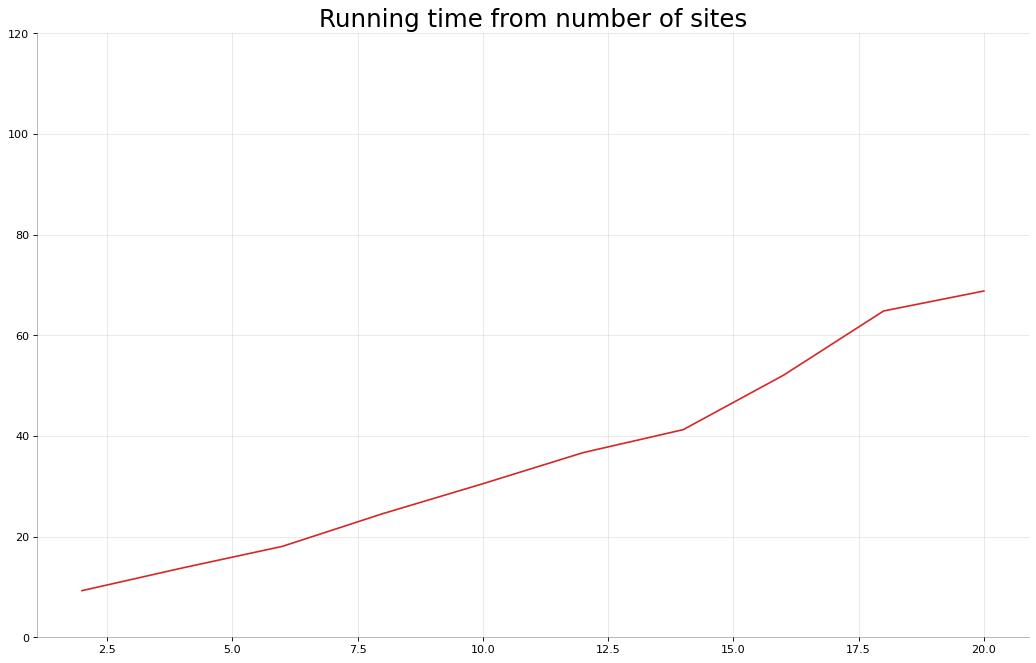

In [32]:
plt.figure(figsize=(16,10), dpi= 80)
plt.plot([2, 4, 6, 8, 10, 12, 14, 16, 18, 20], e_time_sim, color='tab:red')
plt.title("Running time from number of sites", fontsize=22)
plt.grid(axis='both', alpha=.3)
plt.ylim(0, 120)
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3) 
plt.savefig('runtime_sim.jpg')
plt.show()